In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect("database.sqlite")

tables = ['Country', 'League', 'Match', 'Player', 'Player_Attributes', 'Team', 'Team_Attributes']

df_country = pd.read_sql_query("SELECT * FROM Country", conn)
df_league = pd.read_sql_query("SELECT * FROM League", conn)
df_match = pd.read_sql_query("SELECT * FROM Match", conn)
df_player = pd.read_sql_query("SELECT * FROM Player", conn)
df_player_attributes = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)
df_team = pd.read_sql_query("SELECT * FROM Team", conn)
df_team_attributes = pd.read_sql_query("SELECT * FROM Team_Attributes", conn)

conn.close()

In [2]:
import pandas as pd

merged_df = pd.merge(df_team, df_match, left_on='team_api_id', right_on='home_team_api_id', how='inner')

final_df = pd.merge(merged_df, df_league, left_on='league_id', right_on='id', how='inner')

df_team_league_country = final_df[['team_long_name', 'team_api_id', 'name', 'id_x', 'country_id_y']].drop_duplicates()

df_team_league_country.columns = ['team_name', 'team_api_id', 'league_name', 'league_id', 'country_id']

df_team_league_country = pd.merge(df_team_league_country, df_country, left_on='country_id', right_on='id', how='left')

df_team_league_country = df_team_league_country[['team_name', 'team_api_id', 'league_name', 'league_id', 'name', 'country_id']]
df_team_league_country.columns = ['team_name', 'team_api_id', 'league_name', 'league_id', 'country_name', 'country_id']

df_team_league_country = df_team_league_country.sort_values(['country_name', 'league_name', 'team_name'])

df_team_league_country.to_csv('team_league_country_with_ids.csv', index=False)
teams = pd.merge(df_team_attributes,df_team, on='team_fifa_api_id', how='inner')  # Inner join
teams = pd.merge(teams, df_team_league_country, 
                     left_on='team_api_id_x', 
                     right_on='team_api_id', 
                     how='left')

print(teams.shape)
teams = teams[teams['country_id'].isin([1729,4769,7809,10257,21518])]
print(teams.shape)

teams['date'] = pd.to_datetime(teams['date'])

def get_filter_year():
    year = pd.to_datetime('2010-01-01')
    return year

def aggregate_numeric(x):
    return x.mean()

def aggregate_categorical(x):
    return x.mode().iloc[0]

filter_year = get_filter_year()

filtered_players = teams[teams['date'] >= filter_year]

numeric_columns = filtered_players.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = filtered_players.select_dtypes(include=['object']).columns

columns_to_aggregate = [col for col in filtered_players.columns if col not in ['date', 'year']]

aggregated_players = filtered_players.groupby('team_fifa_api_id').agg({
    **{col: aggregate_numeric for col in numeric_columns if col in columns_to_aggregate},
    **{col: aggregate_categorical for col in categorical_columns if col in columns_to_aggregate}
})



teams = aggregated_players
teams.set_index('team_api_id_x', inplace=True)
print(f"Filtered and aggregated data for players from {filter_year} onwards:")
print(teams.head())
print(f"\nShape of the aggregated data: {aggregated_players.shape}")


has_nan = teams.isnull().values.any()
print(f"Does teams contain NaN values? {has_nan}")

nan_count = teams.isnull().sum()
print("NaN count in each column:")
print(nan_count)

(1473, 35)
(924, 35)
Filtered and aggregated data for players from 2010-01-01 00:00:00 onwards:
                id_x  team_fifa_api_id  buildUpPlaySpeed  \
team_api_id_x                                              
9825.0          73.5               1.0         52.333333   
10252.0         79.5               2.0         65.666667   
8655.0         175.5               3.0         52.500000   
8559.0         200.5               4.0         54.666667   
8455.0         309.5               5.0         61.666667   

               buildUpPlayDribbling  buildUpPlayPassing  \
team_api_id_x                                             
9825.0                         51.0           31.166667   
10252.0                        34.5           58.666667   
8655.0                         45.5           63.833333   
8559.0                         35.5           63.833333   
8455.0                         46.5           45.000000   

               chanceCreationPassing  chanceCreationCrossing  \
team_

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_match_filtered = df_match[df_match['date'] > '2010-01-01']

df_combined = df_match_filtered.merge(df_league, left_on='league_id', right_on='id', suffixes=('', '_league'))
df_combined = df_combined.merge(df_country, left_on='country_id', right_on='id', suffixes=('', '_country'))

df_combined = df_combined.merge(df_team, left_on='home_team_api_id', right_on='team_api_id', suffixes=('', '_home_team'))
df_combined = df_combined.merge(df_team, left_on='away_team_api_id', right_on='team_api_id', suffixes=('', '_away_team'))

df_player_attributes['date'] = pd.to_datetime(df_player_attributes['date'])
df_combined['date'] = pd.to_datetime(df_combined['date'])

def get_team_avg_attributes(team_id, match_date):
    team_players = df_player_attributes[
        (df_player_attributes['date'] <= match_date) & 
        (df_player_attributes['player_api_id'].isin(df_combined[df_combined['home_team_api_id'] == team_id]['home_player_1'].unique()))
    ]
    team_players = team_players.sort_values('date').groupby('player_api_id').last()
    return team_players[['overall_rating', 'potential']].mean()

df_combined['home_team_avg_rating'] = df_combined.apply(lambda row: get_team_avg_attributes(row['home_team_api_id'], row['date'])['overall_rating'], axis=1)
df_combined['home_team_avg_potential'] = df_combined.apply(lambda row: get_team_avg_attributes(row['home_team_api_id'], row['date'])['potential'], axis=1)
df_combined['away_team_avg_rating'] = df_combined.apply(lambda row: get_team_avg_attributes(row['away_team_api_id'], row['date'])['overall_rating'], axis=1)
df_combined['away_team_avg_potential'] = df_combined.apply(lambda row: get_team_avg_attributes(row['away_team_api_id'], row['date'])['potential'], axis=1)

df_combined['match_outcome'] = df_combined.apply(lambda row: 1 if row['home_team_goal'] > row['away_team_goal'] else (0 if row['home_team_goal'] == row['away_team_goal'] else -1), axis=1)

attributes = ['buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 
              'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 
              'defencePressure', 'defenceAggression', 'defenceTeamWidth',
              'buildUpPlaySpeedClass', 'buildUpPlayDribblingClass',
              'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
              'chanceCreationPassingClass', 'chanceCreationCrossingClass',
              'chanceCreationShootingClass', 'chanceCreationPositioningClass',
              'defencePressureClass', 'defenceAggressionClass',
              'defenceTeamWidthClass', 'defenceDefenderLineClass']

for attr in attributes:
    df_combined[f'home_{attr}'] = df_combined['home_team_api_id'].map(teams[attr])
    df_combined[f'away_{attr}'] = df_combined['away_team_api_id'].map(teams[attr])

categorical_columns = ['buildUpPlaySpeedClass', 'buildUpPlayDribblingClass', 'buildUpPlayPassingClass',
                       'buildUpPlayPositioningClass', 'chanceCreationPassingClass', 'chanceCreationCrossingClass', 
                       'chanceCreationShootingClass', 'chanceCreationPositioningClass', 'defencePressureClass',
                       'defenceAggressionClass', 'defenceTeamWidthClass', 'defenceDefenderLineClass']

def one_hot_encode_column(column):
    unique_values = column.unique()
    return column.apply(lambda x: list(unique_values).index(x))

for col in categorical_columns:
    df_combined[f'home_{col}'] = one_hot_encode_column(df_combined[f'home_{col}'])
    df_combined[f'away_{col}'] = one_hot_encode_column(df_combined[f'away_{col}'])
features_for_correlation = [
    'home_team_avg_rating', 'home_team_avg_potential',
    'away_team_avg_rating', 'away_team_avg_potential',
    'home_team_goal', 'away_team_goal', 'match_outcome'
]

for attr in attributes:
    features_for_correlation.append(f'home_{attr}')
    features_for_correlation.append(f'away_{attr}')

print(features_for_correlation)
df_combined.head()

['home_team_avg_rating', 'home_team_avg_potential', 'away_team_avg_rating', 'away_team_avg_potential', 'home_team_goal', 'away_team_goal', 'match_outcome', 'home_buildUpPlaySpeed', 'away_buildUpPlaySpeed', 'home_buildUpPlayDribbling', 'away_buildUpPlayDribbling', 'home_buildUpPlayPassing', 'away_buildUpPlayPassing', 'home_chanceCreationPassing', 'away_chanceCreationPassing', 'home_chanceCreationCrossing', 'away_chanceCreationCrossing', 'home_chanceCreationShooting', 'away_chanceCreationShooting', 'home_defencePressure', 'away_defencePressure', 'home_defenceAggression', 'away_defenceAggression', 'home_defenceTeamWidth', 'away_defenceTeamWidth', 'home_buildUpPlaySpeedClass', 'away_buildUpPlaySpeedClass', 'home_buildUpPlayDribblingClass', 'away_buildUpPlayDribblingClass', 'home_buildUpPlayPassingClass', 'away_buildUpPlayPassingClass', 'home_buildUpPlayPositioningClass', 'away_buildUpPlayPositioningClass', 'home_chanceCreationPassingClass', 'away_chanceCreationPassingClass', 'home_chanceCr

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,home_chanceCreationPositioningClass,away_chanceCreationPositioningClass,home_defencePressureClass,away_defencePressureClass,home_defenceAggressionClass,away_defenceAggressionClass,home_defenceTeamWidthClass,away_defenceTeamWidthClass,home_defenceDefenderLineClass,away_defenceDefenderLineClass
0,377,1,1,2009/2010,19,2010-02-03,665626,8635,8342,3,...,0,0,0,0,0,0,0,0,0,0
1,379,1,1,2009/2010,19,2010-02-04,665630,9986,9985,2,...,0,0,0,0,0,0,0,0,0,0
2,382,1,1,2009/2010,19,2010-02-02,665634,8203,9993,1,...,0,0,0,0,0,0,0,0,0,0
3,405,1,1,2009/2010,22,2010-01-30,665665,8342,10001,2,...,0,0,0,0,0,0,0,0,0,0
4,406,1,1,2009/2010,22,2010-01-17,665666,9985,8635,0,...,0,0,0,0,0,0,0,0,0,0


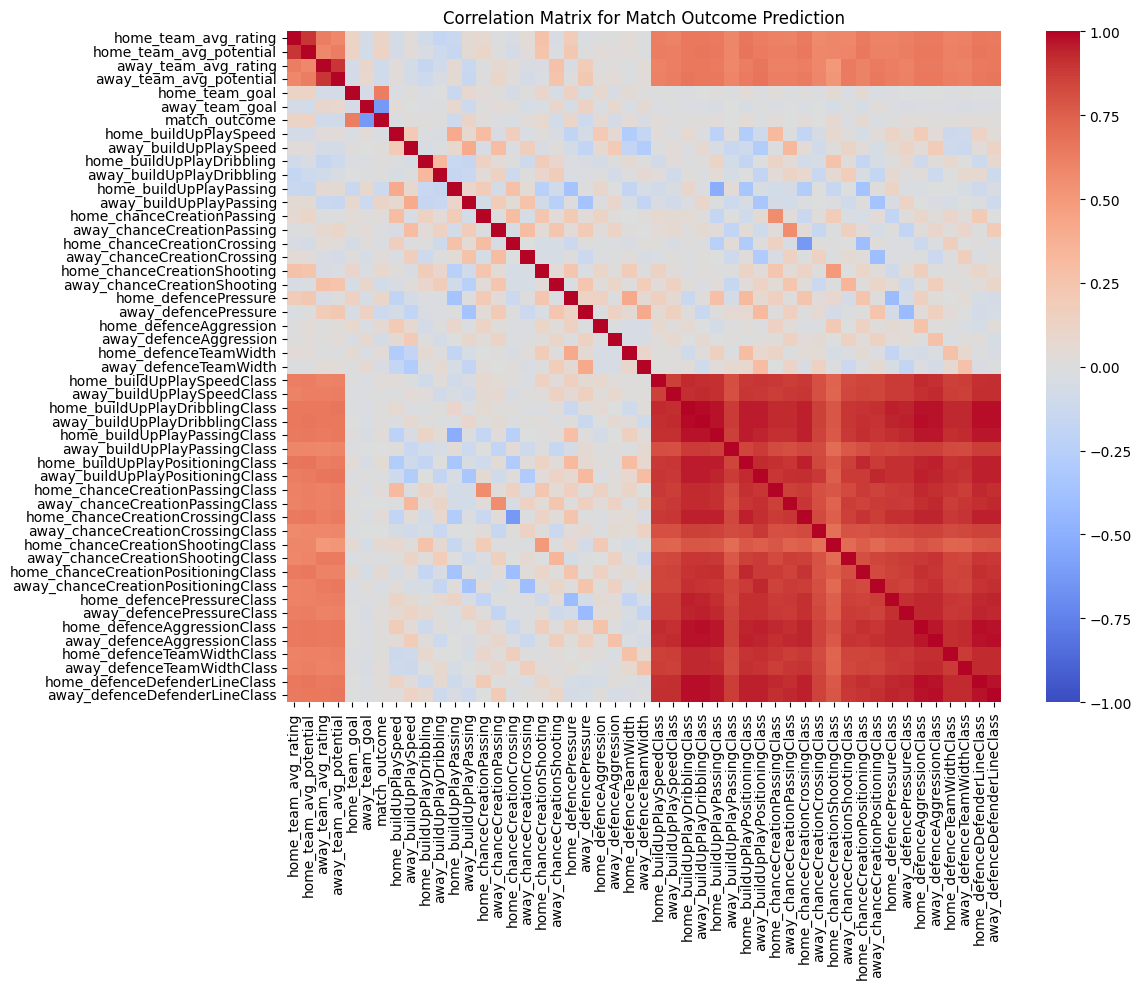

match_outcome                          1.000000
home_team_goal                         0.626126
home_team_avg_potential                0.125314
home_team_avg_rating                   0.112424
away_buildUpPlayPassing                0.111684
home_defencePressure                   0.105439
home_chanceCreationShooting            0.072100
home_chanceCreationShootingClass       0.058646
home_defenceAggression                 0.057516
home_chanceCreationPositioningClass    0.051384
home_buildUpPlayPositioningClass       0.039500
home_defenceTeamWidth                  0.037717
home_chanceCreationPassingClass        0.028820
away_chanceCreationCrossing            0.028555
home_buildUpPlayPassingClass           0.025682
away_defencePressureClass              0.025029
away_defenceTeamWidthClass             0.024605
home_buildUpPlaySpeedClass             0.024179
home_chanceCreationCrossingClass       0.023907
home_chanceCreationPassing             0.022591
home_defenceDefenderLineClass          0

In [4]:

correlation_matrix = df_combined[features_for_correlation].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix for Match Outcome Prediction')
plt.tight_layout()
plt.show()

print(correlation_matrix['match_outcome'].sort_values(ascending=False))


In [5]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.neural_network import MLPClassifier


# features = [
#     'home_team_avg_rating', 'home_team_avg_potential',
#     'away_team_avg_rating', 'away_team_avg_potential'
# ]

# df_combined = df_combined.fillna(0)
# #print(df_combined.isnull().sum())

# X = df_combined[features]
# y = df_combined['match_outcome']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# models = {
#     'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
#     #'XGBoost': XGBClassifier(n_estimators=100, random_state=42),
#     'Neural Network': MLPClassifier(hidden_layer_sizes=(500, 100), max_iter=500, random_state=42)
# }

# results = {}

# for name, model in models.items():
#     model.fit(X_train_scaled, y_train)
    
#     y_pred = model.predict(X_test_scaled)
    
#     accuracy = accuracy_score(y_test, y_pred)
    
#     results[name] = {
#         'accuracy': accuracy,
#         'confusion_matrix': confusion_matrix(y_test, y_pred),
#         'classification_report': classification_report(y_test, y_pred, target_names=['Away Win', 'Draw', 'Home Win'], output_dict=True)
#     }
    
#     print(f"\n{name} Results:")
#     print(f"Accuracy: {accuracy:.4f}")
#     print("\nClassification Report:")
#     print(classification_report(y_test, y_pred, target_names=['Away Win', 'Draw', 'Home Win']))
#     print("\nConfusion Matrix:")
#     print(confusion_matrix(y_test, y_pred))

# plt.figure(figsize=(10, 6))
# accuracies = [results[model]['accuracy'] for model in models]
# plt.bar(models.keys(), accuracies)
# plt.title('Model Accuracy Comparison')
# plt.ylabel('Accuracy')
# plt.ylim(0, 1)
# for i, v in enumerate(accuracies):
#     plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
# plt.show()

# class_names = ['Away Win', 'Draw', 'Home Win']

# fig, axes = plt.subplots(1, 2, figsize=(20, 5))
# for i, (name, model) in enumerate(models.items()):
#     sns.heatmap(results[name]['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[i],
#                 xticklabels=class_names, yticklabels=class_names)
#     axes[i].set_title(f'{name} Confusion Matrix')
#     axes[i].set_xlabel('Predicted')
#     axes[i].set_ylabel('Actual')
# plt.tight_layout()
# plt.show()

# f1_scores = {name: results[name]['classification_report']['weighted avg']['f1-score'] for name in models}
# plt.figure(figsize=(10, 6))
# plt.bar(f1_scores.keys(), f1_scores.values())
# plt.title('Weighted Average F1-Score Comparison')
# plt.ylabel('F1-Score')
# plt.ylim(0, 1)
# for i, v in enumerate(f1_scores.values()):
#     plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
# plt.show()


Random Forest Results:
Accuracy: 0.4549
Classification Report:
              precision    recall  f1-score   support

    Away Win       0.41      0.39      0.40      1187
        Draw       0.27      0.19      0.22      1090
    Home Win       0.53      0.65      0.58      1935

    accuracy                           0.45      4212
   macro avg       0.41      0.41      0.40      4212
weighted avg       0.43      0.45      0.44      4212

Confusion Matrix:
[[ 459  218  510]
 [ 291  203  596]
 [ 361  320 1254]]

Gradient Boosting Results:
Accuracy: 0.5021
Classification Report:
              precision    recall  f1-score   support

    Away Win       0.49      0.35      0.41      1187
        Draw       0.26      0.02      0.04      1090
    Home Win       0.51      0.87      0.64      1935

    accuracy                           0.50      4212
   macro avg       0.42      0.41      0.36      4212
weighted avg       0.44      0.50      0.42      4212

Confusion Matrix:
[[ 419   23  74

Epoch [10/50], Loss: 1.0452, Training Accuracy: 0.4753


Epoch [20/50], Loss: 1.0472, Training Accuracy: 0.4715


Epoch [30/50], Loss: 1.0455, Training Accuracy: 0.4700


Epoch [40/50], Loss: 1.0454, Training Accuracy: 0.4693


/home/svrao3/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/svrao3/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/svrao3/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [50/50], Loss: 1.0453, Training Accuracy: 0.4705

Neural Network Results:
Accuracy: 0.4490
Classification Report:
              precision    recall  f1-score   support

    Away Win       0.36      0.77      0.49      1187
        Draw       0.00      0.00      0.00      1090
    Home Win       0.59      0.51      0.55      1935

    accuracy                           0.45      4212
   macro avg       0.32      0.42      0.34      4212
weighted avg       0.37      0.45      0.39      4212

Confusion Matrix:
[[909   0 278]
 [684   0 406]
 [953   0 982]]

Neural Network Results:
Accuracy: 0.4490
Classification Report:
              precision    recall  f1-score   support

    Away Win       0.36      0.77      0.49      1187
        Draw       0.00      0.00      0.00      1090
    Home Win       0.59      0.51      0.55      1935

    accuracy                           0.45      4212
   macro avg       0.32      0.42      0.34      4212
weighted avg       0.37      0.45      0.39 

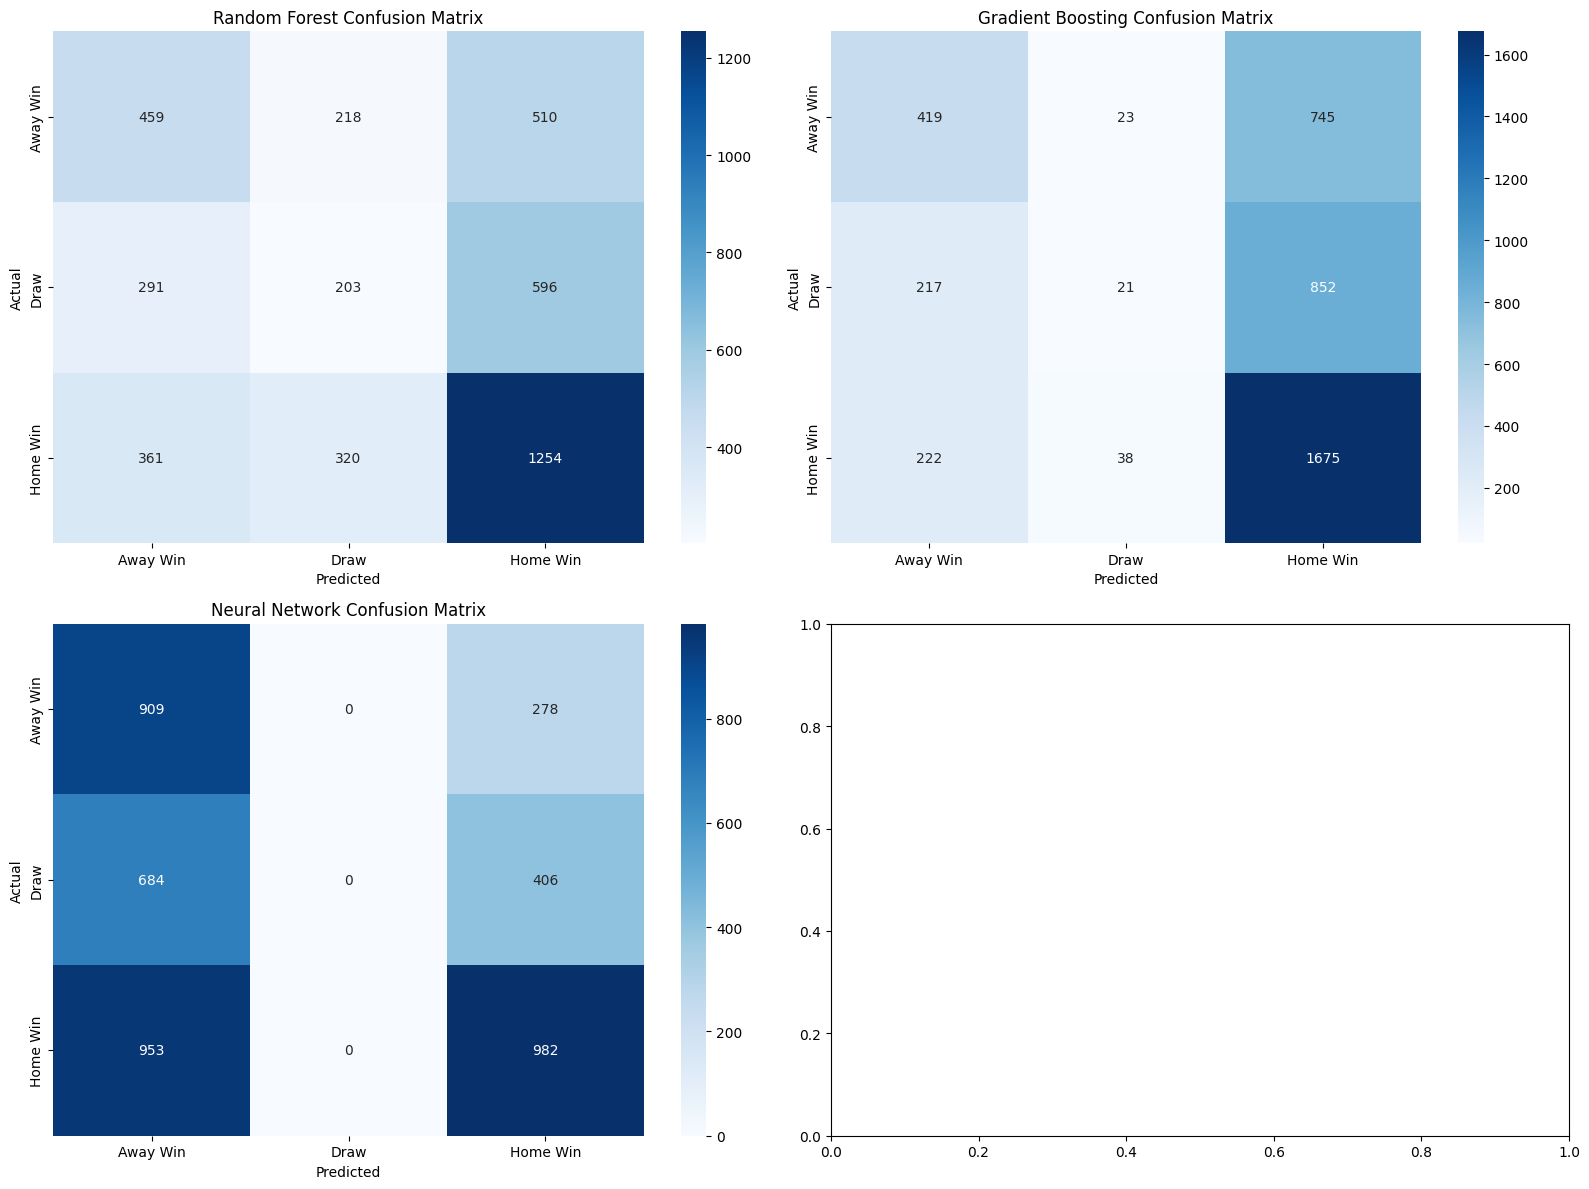

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Early stopping utility
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None

    def check(self, current_loss):
        if self.best_loss is None or (self.best_loss - current_loss) > self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            return False  # Continue training
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True  # Stop training
            return False

# Neural network architecture
class MatchOutcomeNN(nn.Module):
    def __init__(self, input_size):
        super(MatchOutcomeNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 3)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

def train_pytorch_nn(model, X_train, y_train, X_test, y_test, num_epochs=50, batch_size=32):
    y_train = y_train.replace({-1: 0, 1: 1, 0: 2})
    y_test = y_test.replace({-1: 0, 1: 1, 0: 2})
    
    # Class weights to handle imbalance
    class_weights = torch.tensor([1.5, 1.0, 1.2])
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

    # DataLoader for batching
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # Optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
    scheduler = StepLR(optimizer, step_size=100, gamma=0.5)
    early_stopping = EarlyStopping(patience=20, min_delta=0.001)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            running_loss += loss.item()
        
        scheduler.step()
        
        if (epoch+1) % 10 == 0:
            train_accuracy = correct_predictions / total_samples
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Training Accuracy: {train_accuracy:.4f}')

    # Evaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        probabilities = nn.Softmax(dim=1)(outputs)
        _, predicted = torch.max(outputs, 1)
        
        predicted_mapped = predicted.numpy()
        predicted_mapped = np.where(predicted_mapped == 0, -1, predicted_mapped)
        predicted_mapped = np.where(predicted_mapped == 2, 0, predicted_mapped)
        predicted_mapped = np.where(predicted_mapped == 1, 1, predicted_mapped)

        nn_probabilities = probabilities.numpy()
    
    return predicted_mapped, nn_probabilities

# Data preparation
features = [
    'home_team_avg_rating', 'home_team_avg_potential',
    'away_team_avg_rating', 'away_team_avg_potential'
]
team_attr = [
    'buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 
    'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 
    'defencePressure', 'defenceAggression', 'defenceTeamWidth',
    'buildUpPlaySpeedClass', 'buildUpPlayDribblingClass',
    'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
    'chanceCreationPassingClass', 'chanceCreationCrossingClass',
    'chanceCreationShootingClass', 'chanceCreationPositioningClass',
    'defencePressureClass', 'defenceAggressionClass',
    'defenceTeamWidthClass', 'defenceDefenderLineClass'
]
features.extend([f'home_{attr}' for attr in team_attr])
features.extend([f'away_{attr}' for attr in team_attr])

df_combined = df_combined.fillna(0)

X = df_combined[features]
y = df_combined['match_outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train individual models and get metrics
rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
rf_class_report = classification_report(y_test, rf_predictions, target_names=['Away Win', 'Draw', 'Home Win'])

print("\nRandom Forest Results:")
print(f"Accuracy: {rf_accuracy:.4f}")
print("Classification Report:")
print(rf_class_report)
print("Confusion Matrix:")
print(rf_conf_matrix)

gb_classifier.fit(X_train_scaled, y_train)
gb_predictions = gb_classifier.predict(X_test_scaled)
gb_accuracy = accuracy_score(y_test, gb_predictions)
gb_conf_matrix = confusion_matrix(y_test, gb_predictions)
gb_class_report = classification_report(y_test, gb_predictions, target_names=['Away Win', 'Draw', 'Home Win'])

print("\nGradient Boosting Results:")
print(f"Accuracy: {gb_accuracy:.4f}")
print("Classification Report:")
print(gb_class_report)
print("Confusion Matrix:")
print(gb_conf_matrix)

input_size = X_train_scaled.shape[1]
nn_model = MatchOutcomeNN(input_size)
nn_predictions, nn_probabilities = train_pytorch_nn(nn_model, X_train_scaled, y_train, X_test_scaled, y_test, num_epochs=50)

# Since predictions are already mapped, use them directly
nn_accuracy = accuracy_score(y_test, nn_predictions)
nn_conf_matrix = confusion_matrix(y_test, nn_predictions)
nn_class_report = classification_report(y_test, nn_predictions, target_names=['Away Win', 'Draw', 'Home Win'])

print("\nNeural Network Results:")
print(f"Accuracy: {nn_accuracy:.4f}")
print("Classification Report:")
print(nn_class_report)
print("Confusion Matrix:")
print(nn_conf_matrix)

print("\nNeural Network Results:")
print(f"Accuracy: {nn_accuracy:.4f}")
print("Classification Report:")
print(nn_class_report)
print("Confusion Matrix:")
print(nn_conf_matrix)

# Plot confusion matrices for each model
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
model_names = ["Random Forest", "Gradient Boosting", "Neural Network"]
conf_matrices = [rf_conf_matrix, gb_conf_matrix, nn_conf_matrix]

for i, (ax, conf_matrix, model_name) in enumerate(zip(axes.flatten(), conf_matrices, model_names)):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Away Win', 'Draw', 'Home Win'],
                yticklabels=['Away Win', 'Draw', 'Home Win'])
    ax.set_title(f'{model_name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [ ]:
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

# Define the neural network with skorch wrapper
class MatchOutcomeNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 256, 128, 64], dropout=0.4):
        super(MatchOutcomeNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.bn4 = nn.BatchNorm1d(hidden_sizes[3])
        self.fc5 = nn.Linear(hidden_sizes[3], 3)  # 3 output classes
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

input_size = X_train_scaled.shape[1]
# Define the skorch neural network classifier
net = NeuralNetClassifier(
    MatchOutcomeNN,
    module__input_size=input_size,
    max_epochs=200,
    lr=0.001,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    batch_size=32,
    iterator_train__shuffle=True,
    train_split=None,  # Disable validation split, as we'll use GridSearchCV for cross-validation
)

# Define parameter grid for grid search
param_grid = {
    'module__hidden_sizes': [[128, 256, 128, 64], [64, 128, 64, 32], [256, 128, 64]],
    'module__dropout': [0.3, 0.4, 0.5],
    'optimizer__lr': [0.001, 0.0005, 0.0001],
    'batch_size': [32, 64, 128],
}

# Use GridSearchCV to find the best hyperparameters
grid = GridSearchCV(net, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train_scaled.astype(np.float32), y_train.replace({-1: 0, 1: 1, 0: 2}).to_numpy().astype(np.int64))

# Print best hyperparameters
print("Best hyperparameters found:", grid.best_params_)
print("Best validation accuracy:", grid.best_score_)

# Retrain the network on the full training set with the best hyperparameters
best_net = grid.best_estimator_
best_net.fit(X_train_scaled.astype(np.float32), y_train.replace({-1: 0, 1: 1, 0: 2}).to_numpy().astype(np.int64))

# Evaluate on the test set
nn_predictions = best_net.predict(X_test_scaled.astype(np.float32))
nn_predictions = pd.Series(nn_predictions).replace({0: -1, 1: 0, 2: 1})  # Map back to original labels

nn_accuracy = accuracy_score(y_test, nn_predictions)
nn_conf_matrix = confusion_matrix(y_test, nn_predictions)
nn_class_report = classification_report(y_test, nn_predictions, target_names=['Away Win', 'Draw', 'Home Win'])

print("\nNeural Network Results (Best Model):")
print(f"Accuracy: {nn_accuracy:.4f}")
print("Classification Report:")
print(nn_class_report)
print("Confusion Matrix:")
print(nn_conf_matrix)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1026  1.0971
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0695  1.3651
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0714  1.3511
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0762  1.3585
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0704  1.3362
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0653  1.5373
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1030  1.3714
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0734  1.5426
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0883  1.4265
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0712  1.5540
  epoch    train_loss     dur
------- 

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    158        0.9979  1.3300
    178        1.0110  1.1977
    182        1.0086  1.1793
    180        1.0092  1.2096
    179        0.9916  1.0620
    164        0.9996  1.3379
    159        1.0024  1.3415
    180        1.0100  1.1893
    184        1.0050  0.9895
    177        0.9969  1.0874
    159        1.0025  1.3357
    181        1.0092  1.0063
    168        0.9947  1.3283
    172        0.9926  1.1110
    180        1.0071  1.1671
    179        1.0093  1.1967
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1304  1.3182
    183        1.0069  1.1744
    159        0.9983  1.3314
    180        0.9939  1.1250
    181        1.0067  1.2175
    185        1.0046  1.0189
    165        0.9982  1.3279
    181        1.0074  1.1693
    178        0.9981  1.1156
    160        1.0040  1.3278
    182        1.0086  1.0170
    160        1.0022  1.3215
    173        0.9959  1.0754
    181        1.0050  1.1615
    169        0.9945  1.3334
    181   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     13        1.0401  1.2933
    171        1.0024  1.2511
    171        1.0029  1.2909
    196        1.0078  1.1496
    192        0.9964  1.0993
    192        1.0088  1.1786
    195        1.0102  1.1700
    180        0.9931  1.2980
    194        1.0068  1.1756
    194        1.0043  1.1885
    187        0.9938  1.0886
    196        1.0046  0.9858
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1321  0.9637
    171        0.9966  1.3303
    195        0.9898  1.0640
    177        0.9961  1.3309
    193        0.9939  1.0532
     14        1.0384  1.2488
    197        1.0075  1.1800
    172        1.0020  1.3807
    172        1.0021  1.3475
    193        1.0127  1.2055
    196        1.0089  1.2115
    188        0.9905  1.0312
    181        0.9956  1.3371
    195        1.0055  1.1894
    195        1.0038  1.1976
      2        1.0960  0.9330
    196        0.9938  1.0244
    197        1.0085  1.2355
    172        0.9947  1.3571
    194   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    196        1.0112  1.2702
    180        0.9978  1.4189
    199        1.0073  1.2875
    198        1.0042  1.2559
    198        1.0071  1.2636
    175        1.0005  1.4279
    192        0.9896  1.0134
    175        1.0023  1.4318
    197        0.9927  1.4367
    184        0.9971  1.4277
    200        1.0038  1.2933
    200        0.9894  1.0179
     18        1.0345  1.2099


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/svrao3/.lo

      6        1.0586  1.2631
    175        0.9947  1.4365
    197        1.0104  1.2696
    200        1.0099  1.2876
    199        1.0053  1.2493
    193        0.9924  0.9899
    199        1.0042  1.2633
    181        0.9952  1.4276
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0812  1.4053


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    176        1.0010  1.4105
    176        1.0035  1.4138
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0814  1.0090
    198        0.9947  1.4015
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0878  1.1276
    185        0.9949  1.4044
     19        1.0342  1.2071
    194        0.9925  1.0094
      7        1.0520  1.2480
    198        1.0088  1.2470
    200        1.0030  1.2357
    176        0.9951  1.4102
    200        1.0030  1.2504
    182        0.9928  1.4108
      2        1.0430  1.3847


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/svrao3/.lo

      2        1.0493  1.0147
      2        1.0464  1.0278
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0893  1.4345
    177        1.0026  1.3984
    177        1.0032  1.4097
     20        1.0366  1.2173
    199        0.9934  1.3937
    186        0.9934  1.3985
    195        0.9912  1.0124
      8        1.0490  1.2951
    199        1.0098  1.2503
      3        1.0383  1.0107
    177        0.9914  1.4231
      3        1.0386  1.2407
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0904  1.4171
      3        1.0374  1.4189
    183        0.9922  1.4478
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1098  1.4475
      2        1.0566  1.4725
     21        1.0333  1.1883
    196        0.9892  1.2354    178        0.9995  1.4510

    178        1.0047  1.4815
    200        0.9943  1.4473
    187        0.9949  1.4545
      4        1.0348  0.9839
      9        1.0522  1.2919
    200   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/svrao3/.lo

    178        0.9929  1.4776
    197        0.9912  1.0021
      2        1.0594  1.4476
      4        1.0335  1.4553
     22        1.0315  1.2019
      4        1.0349  1.5292
    184        0.9964  1.4808
      2        1.0616  1.4708
      5        1.0333  1.0111
      3        1.0417  1.4861
    179        0.9984  1.4539
    179        1.0026  1.4899
     10        1.0465  1.2813
    188        0.9941  1.4670
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1397  1.4569
    198        0.9912  1.0065
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1262  1.4705
     23        1.0317  1.2059
    179        0.9926  1.4616
      6        1.0306  1.0111
      3        1.0484  1.4271
      5        1.0331  1.4308
     11        1.0437  0.9288
    185        0.9949  1.4582
      5        1.0355  1.4925
      3        1.0469  1.4472
      4        1.0371  1.4650
    180        1.0006  1.4383
    180        1.0017  1.4574
    199   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    181        1.0014  1.4543
    190        0.9938  1.4276
      3        1.0834  1.4313
     25        1.0319  1.2371
      3        1.0953  1.4413
    181        0.9922  1.4400
      7        1.0317  1.3413
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1690  1.0293
      5        1.0358  1.4137
     14        1.0404  0.9347
      9        1.0270  1.0292
    187        0.9940  1.4423
      5        1.0369  1.4395
      7        1.0314  1.4813
      6        1.0328  1.4689
    182        0.9982  1.4324
    182        1.0013  1.4740
    191        0.9949  1.4348
     26        1.0295  1.2190
      4        1.0701  1.4444
      2        1.0930  1.0449
     10        1.0299  1.0384
      4        1.0793  1.4588
     15        1.0392  1.1645
    182        0.9922  1.4663
      8        1.0266  1.4280
      6        1.0361  1.4413
    188        0.9945  1.4750
      6        1.0327  1.4639
      8        1.0292  1.5000
      7        1.0289  1.4806
     27   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     25        1.0289  1.3475
     13        1.0448  1.5229
     17        1.0227  1.5187
     15        1.0283  1.4950
    191        0.9931  1.5217
     15        1.0345  0.9840
     38        1.0277  1.1817
     15        1.0269  1.5097
    197        0.9920  1.5108
    192        1.0016  1.4874
     23        1.0247  1.0572
     17        1.0257  1.5227
     16        1.0248  1.5181
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0891  1.2779
     14        1.0383  1.4662
     26        1.0268  1.3006
     16        1.0339  0.9904
    192        1.0010  1.5166
     18        1.0238  1.4563
     14        1.0379  1.4858
     16        1.0277  1.4560
     39        1.0245  1.1839
     24        1.0257  0.9797
    192        0.9899  1.4865
     16        1.0254  1.4901
    198        0.9911  1.4962
    193        1.0019  1.4756
      2        1.0575  1.2898
     17        1.0326  0.9904
     18        1.0265  1.5139
     17        1.0246  1.5053
     27   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     18        1.0332  0.9964
     28        1.0210  1.0006
    195        1.0015  1.4871
     19        1.0235  1.4260
     21        1.0244  1.4657
     17        1.0357  1.4528
      5        1.0370  1.2568
    195        0.9864  1.4484
     21        1.0310  1.0018
     30        1.0268  1.2817
     19        1.0236  1.4454
     43        1.0261  1.2016
    196        1.0001  1.4322
     19        1.0296  0.9890
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0875  1.2647
     29        1.0234  0.9912
     20        1.0243  1.4296
     21        1.0224  1.4606
      6        1.0354  1.2508
     20        1.0264  1.4213
    196        1.0015  1.4782
     22        1.0242  1.4403
     22        1.0292  1.0099
     18        1.0351  1.4450
     20        1.0367  0.9976
    196        0.9943  1.4357
     31        1.0242  1.2755
     30        1.0210  1.0021
     44        1.0253  1.2076
      2        1.0513  1.2616
     20        1.0219  1.4351
    197   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      6        1.0335  1.3118
     24        1.0249  1.4727
     25        1.0281  1.5028
     35        1.0224  1.4025
     26        1.0231  1.5166
     22        1.0289  1.5163
    200        1.0024  1.5413
     28        1.0267  1.0574
    200        0.9892  1.5129
     11        1.0303  1.3042


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/svrao3/.lo

     49        1.0235  1.1576
     24        1.0235  1.5189
     25        1.0224  1.5059
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1053  1.3424
     36        1.0244  1.3546
     26        1.0234  1.5819
      7        1.0333  1.3375
     25        1.0226  1.5068
     26        1.0257  1.5168
     36        1.0216  1.5104
     27        1.0207  1.5497
     23        1.0288  1.5400
     50        1.0219  1.1599
     12        1.0294  1.3310
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1146  1.4280
     29        1.0282  1.5726
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0966  1.3563
     25        1.0222  1.5592
      2        1.0547  1.3677
     26        1.0229  1.5478
      8        1.0325  1.3596
     37        1.0244  1.4962
     27        1.0242  1.5778
     26        1.0244  1.5368
     51        1.0226  1.2649
     27        1.0306  1.5470
     37        1.0213  1.5349
     13   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    127        1.0119  1.4944
    149        1.0133  1.3267
    116        1.0158  1.3048
    148        1.0102  0.9858
    115        1.0165  1.3367
    129        1.0131  1.4851
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0964  0.8847
    129        1.0183  1.2923
    122        1.0192  1.3269
    132        1.0110  1.4842
    130        1.0125  1.5037
    154        1.0113  1.2856
    128        1.0099  1.4820
    120        1.0189  1.3170
    126        1.0113  1.5505
    150        1.0108  1.3462
    117        1.0174  1.3218
    127        1.0098  1.5108
    128        1.0130  1.5329
    149        1.0103  1.3529
      2        1.0733  0.8727
    116        1.0156  1.3422
    130        1.0162  1.3102
    130        1.0099  1.5108
    123        1.0161  1.3589
    155        1.0102  1.2862
    133        1.0111  1.5473
      3        1.0570  0.8893
    121        1.0186  1.3266
    131        1.0125  1.5344
    129        1.0117  1.5062
    151   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    166        1.0079  1.5457
    195        1.0078  1.3451
    174        1.0063  1.4865
     59        1.0205  0.9361
    168        1.0112  1.5230
    162        1.0130  1.3192
    176        1.0155  1.3055
    193        1.0082  1.2930
    169        1.0029  1.4755
    170        1.0161  1.3247
    174        1.0075  1.5280
    167        1.0140  1.3069
    168        1.0086  1.4874
    164        1.0136  1.2895
     60        1.0185  0.8904
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1330  1.2979
    172        1.0084  1.4565
    196        1.0099  1.3237
    167        1.0059  1.4991
    163        1.0117  1.3097
    175        1.0069  1.4662
    177        1.0156  1.2963
    169        1.0063  1.5019
    194        1.0059  1.2966
    171        1.0136  1.3233
     61        1.0215  0.9000
    170        1.0062  1.4657
    175        1.0076  1.5110
    168        1.0138  1.3044
    165        1.0125  1.2874
      2        1.1032  1.3009
    169   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    172        1.0060  1.4974
    176        1.0103  1.4693
    198        1.0075  1.3569
    175        1.0116  1.3298
    171        1.0062  1.5078
     67        1.0177  0.8938
    179        1.0040  1.4755
    172        1.0166  1.3157
    169        1.0145  1.3226
      6        1.0665  1.3125
    173        1.0081  1.5064
    174        1.0042  1.4735
    168        1.0119  1.3070
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1330  1.3134
    182        1.0171  1.2956
     68        1.0207  0.8843
    179        1.0090  1.5290
    199        1.0064  1.2935
    173        1.0050  1.4863
    176        1.0138  1.3183
    177        1.0095  1.4572
    173        1.0155  1.3049
    170        1.0177  1.3066
    172        1.0041  1.4978
    180        1.0053  1.4670
      7        1.0618  1.3899
     69        1.0186  0.8953
    174        1.0112  1.5024
    175        1.0017  1.4750
    169        1.0135  1.3201
      2        1.1023  1.3259
    183   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    173        1.0099  1.5272
      8        1.0551  1.3422
    181        1.0060  1.4979
    175        1.0059  1.5287
    170        1.0134  1.3340
    184        1.0129  1.3176
      3        1.0895  1.3395
    176        1.0057  1.5021
     71        1.0190  0.8838
    178        1.0155  1.3329
    181        1.0058  1.5376
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1802  1.2335
    179        1.0086  1.4661
    175        1.0161  1.3102
    172        1.0141  1.3115
    175        1.0065  1.4986
      9        1.0559  1.3338
     72        1.0178  0.8868
    174        1.0077  1.4974
    182        1.0043  1.4636
    185        1.0136  1.2889
    171        1.0135  1.3020
      4        1.0805  1.3037
    176        1.0083  1.4931
    177        1.0042  1.4761
    179        1.0151  1.3148
      2        1.1167  1.1762
     73        1.0195  0.8928
    176        1.0153  1.3013
    173        1.0111  1.3009
    182        1.0074  1.5020
    180   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    188        1.0137  1.2985
    194        1.0148  1.3248
    189        1.0082  1.4924
    196        1.0035  1.4717
    195        1.0048  1.5054
     95        1.0176  0.9077
     20        1.0353  1.3350
    191        1.0123  1.3524
    188        1.0060  1.5049
     25        1.0306  1.3377
     19        1.0374  1.2529
    187        1.0146  1.3341
    191        1.0021  1.5187
    190        1.0091  1.5363
     96        1.0183  0.9157
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0887  1.4972
    194        1.0080  1.4885
    189        1.0146  1.3261
    195        1.0143  1.3563
    190        1.0059  1.5279
     21        1.0367  1.3497
    197        1.0049  1.5017
    196        1.0073  1.5246
    192        1.0132  1.3667
     26        1.0333  1.3372
     97        1.0175  0.8910
    189        1.0043  1.5217
     20        1.0360  1.3058
    188        1.0125  1.3377
    192        1.0019  1.5290
    191        1.0084  1.5351
      2   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    102        1.0180  0.9086
    192        1.0062  1.5233
    193        1.0128  1.3295
    199        1.0121  1.3535
    195        1.0006  1.5017
     25        1.0342  1.3512
      5        1.0379  1.4960
    198        1.0050  1.4855
    196        1.0154  1.3523
    194        1.0050  1.5295
     24        1.0341  1.3050
     30        1.0314  1.3388
    103        1.0176  0.8812
    192        1.0114  1.3368
    194        1.0061  1.5249
    200        1.0054  1.5308
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0955  1.4955
    194        1.0124  1.3237
    193        1.0056  1.5251
    200        1.0134  1.3574


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    104        1.0156  0.8701
     26        1.0386  1.3504


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    196        1.0048  1.5106
    197        1.0156  1.3683
     25        1.0338  1.3152
      6        1.0348  1.5047
    199        1.0081  1.4986
     31        1.0309  1.3491
    195        1.0078  1.5431
    193        1.0103  1.3510
    105        1.0193  0.9554
    195        1.0078  1.5356
    195        1.0144  1.3277
      2        1.0589  1.5089
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0896  1.5928
    194        1.0054  1.5324
     27        1.0366  1.3490
     26        1.0315  1.3112
    198        1.0125  1.4449
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1187  1.5364
    197        1.0015  1.5154
     32        1.0312  1.3525
    106        1.0172  0.8781
      7        1.0334  1.5041
    200        1.0059  1.5047
    194        1.0094  1.3842
    196        1.0034  1.5780


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    196        1.0111  1.3280
    196        1.0075  1.5356
      3        1.0466  1.5063
    107        1.0175  0.8914
     28        1.0331  1.3474
    195        1.0032  1.5259
     27        1.0315  1.2949
      2        1.0549  1.5442
    199        1.0141  1.3530
     33        1.0293  1.4084
      2        1.0679  1.5344
    195        1.0122  1.3898
      8        1.0327  1.4998
    198        1.0061  1.5984
    197        1.0045  1.5349
    108        1.0170  0.9054
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1154  1.4849
    197        1.0103  1.3141
    197        1.0081  1.5254
     29        1.0348  1.3382
      4        1.0410  1.4941
     28        1.0324  1.2458
    200        1.0132  1.3348
    196        1.0032  1.5235
      3        1.0420  1.5114
     34        1.0289  1.3371
    109        1.0162  0.9236


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    196        1.0113  1.4306
      3        1.0461  1.5404
      9        1.0327  1.5052
    199        1.0033  1.5338
    198        1.0118  1.3377
    198        1.0053  1.5565
      2        1.0736  1.5111
    110        1.0176  0.9109
     29        1.0281  1.3394
     30        1.0330  1.3900
    198        1.0041  1.5524
      5        1.0399  1.5294
     35        1.0285  1.3652
    197        1.0019  1.5510
      4        1.0387  1.5464
    197        1.0147  1.4019
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1175  1.5499
    111        1.0165  0.8630
     10        1.0299  1.5268
      4        1.0439  1.5652
    199        1.0126  1.3518
    200        1.0057  1.5574
      3        1.0536  1.5252
    199        1.0059  1.5700


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     30        1.0278  1.3461
     31        1.0339  1.3655
    199        1.0065  1.5620
    112        1.0177  0.8766
      6        1.0371  1.5390
     36        1.0295  1.3728
      5        1.0371  1.5429
    198        1.0042  1.5549
    198        1.0130  1.4049
      2        1.0731  1.5535
    200        1.0136  1.3498
     11        1.0292  1.5275
      5        1.0385  1.5650
    113        1.0160  0.8770


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      4        1.0466  1.5281
     31        1.0307  1.3429
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1665  1.5340
    200        1.0054  1.5742
     32        1.0309  1.3672


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     37        1.0269  1.3627
    200        1.0063  1.5544
      7        1.0346  1.5336
    114        1.0153  0.8966
    199        1.0104  1.4124
      6        1.0368  1.5440
    199        1.0062  1.5483


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      3        1.0502  1.5612
     12        1.0306  1.5345
      6        1.0364  1.5611
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1602  1.5241
     32        1.0283  1.3426
     33        1.0338  1.3573
      5        1.0388  1.5124
      2        1.1111  1.5157
    115        1.0167  0.8974
     38        1.0286  1.3646
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1848  1.5491
      8        1.0337  1.5159
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0874  1.3369
    200        1.0135  1.3933


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      7        1.0348  1.5258
    200        1.0045  1.5321
    116        1.0163  0.9064
     33        1.0285  1.2357
      4        1.0436  1.5293
     13        1.0261  1.5109
     34        1.0351  1.3468


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      2        1.1245  1.5016
      7        1.0328  1.5424
      6        1.0356  1.4933
      3        1.0995  1.4942
     39        1.0287  1.3517
      2        1.1184  1.5318
      2        1.0628  1.3229
    117        1.0186  0.8845
      9        1.0329  1.4911
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1134  1.3583
     34        1.0309  1.2734
      8        1.0324  1.5781
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0966  1.3188
     35        1.0317  1.3380
      5        1.0387  1.5226
     14        1.0298  1.4997
    118        1.0160  0.8844
      3        1.0996  1.4990
      8        1.0327  1.5325
     40        1.0253  1.3404
      7        1.0361  1.4931
      4        1.0917  1.4974
      3        1.0519  1.3348
      3        1.1024  1.5391
     10        1.0318  1.5145
      2        1.0654  1.3724
     35        1.0280  1.3356
      2        1.0650  1.3442
     36        1.0322  1.3599
      9   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     75        1.0180  1.4949
     78        1.0219  1.3065
    137        1.0185  1.1532
     84        1.0198  1.4204
     83        1.0203  1.4672
     78        1.0240  1.4770
     81        1.0224  1.3198
     71        1.0236  1.4914
     70        1.0214  1.5228
    112        1.0200  1.3284
     79        1.0253  1.3236
     81        1.0196  1.5257
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1113  1.1745
     76        1.0187  1.4828
    120        1.0193  1.3526
     79        1.0217  1.3149
    138        1.0173  1.3254
     75        1.0185  1.5043
     76        1.0181  1.5131
     85        1.0171  1.4545
     84        1.0201  1.4636
     82        1.0243  1.3102
     79        1.0206  1.4749
    113        1.0199  1.3150
     72        1.0210  1.4766
     80        1.0224  1.3105
      2        1.0779  1.1492
     71        1.0216  1.4933
     82        1.0231  1.5026
    121        1.0193  1.3102
     77        1.0187  1.4589
     80   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    123        1.0185  1.5394
    128        1.0145  1.5160
    126        1.0133  1.5350
    143        1.0238  1.3733
     82        1.0232  0.8952
    124        1.0165  1.5406
    170        1.0183  1.3680
    135        1.0153  1.5472
    130        1.0193  1.5669
    140        1.0171  1.3585
    178        1.0175  1.3881
    141        1.0174  1.5135
     83        1.0225  0.9038
    140        1.0148  1.5447
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1373  1.3302
    138        1.0204  1.3563
    127        1.0161  1.5643
    144        1.0200  1.3689
    129        1.0167  1.5117
    124        1.0182  1.5365
    127        1.0172  1.5311
    171        1.0161  1.3608
    125        1.0167  1.5336
     84        1.0218  0.8856
    136        1.0159  1.5329
    141        1.0192  1.3558
    131        1.0175  1.5637
    179        1.0147  1.3719
    142        1.0179  1.5182
      2        1.0817  1.3352
    139        1.0222  1.3645
    141   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    166        1.0176  1.2879
    161        1.0175  1.4461
    112        1.0227  0.9029
    160        1.0152  1.0741
    193        1.0160  1.2843
     25        1.0314  1.1862
    149        1.0130  1.4192
    150        1.0148  1.4297
    163        1.0192  1.2704
    156        1.0157  1.4171
    144        1.0153  1.4477
    145        1.0173  1.4449
    113        1.0217  0.8921
    161        1.0190  1.2792
    161        1.0143  0.9827
    147        1.0160  1.4736
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1268  1.3009
    167        1.0202  1.2948
    149        1.0147  1.4792
     26        1.0302  1.1783
    194        1.0174  1.2954
    162        1.0185  1.4548
    164        1.0179  1.2897
    150        1.0135  1.4371
    151        1.0145  1.4566
    114        1.0221  0.8911
    162        1.0162  0.9830
    157        1.0174  1.4599
    145        1.0178  1.4703
    162        1.0187  1.2934
    146        1.0156  1.4629
      2   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    150        1.0164  1.3002
    170        1.0166  1.2378
    163        1.0132  1.0266
    151        1.0154  1.3857
     33        1.0270  1.2334
    169        1.0170  1.0382
    153        1.0145  1.4017
    168        1.0222  1.2280
    155        1.0148  1.3741
    168        1.0141  1.3769
    123        1.0210  0.9568
      8        1.0397  1.2424
    174        1.0170  1.2278
    156        1.0145  1.3568
    157        1.0134  1.3705
    151        1.0155  1.0341
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1675  1.2350
    171        1.0171  1.2391
    164        1.0151  1.2344
    170        1.0134  1.0180
    152        1.0160  1.3927
     34        1.0289  1.2185
    124        1.0208  0.9329
    169        1.0191  1.2465
    154        1.0151  1.4305
    156        1.0125  1.4008
      9        1.0414  1.2477
    152        1.0150  1.0280
    169        1.0127  1.4081
    175        1.0212  1.2545
    157        1.0132  1.3962
      2   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    192        1.0147  1.4447
    195        1.0133  1.4369
     34        1.0288  1.2644
    180        1.0142  1.4368
    159        1.0169  0.8916
    176        1.0153  1.4763
    179        1.0121  1.4476
     27        1.0400  1.2887
     61        1.0234  1.2228
    176        1.0130  1.4593
    175        1.0159  1.4592
    197        1.0173  1.3376
    188        1.0137  1.2866
    195        1.0209  1.2912
  epoch    train_loss     dur
-------  ------------  ------
      1        1.2618  1.2995
    160        1.0200  0.8893
    180        1.0128  1.4372
     35        1.0245  1.2809
    193        1.0150  1.4570
    196        1.0112  1.4459
    181        1.0129  1.4494
     28        1.0374  1.2919
    180        1.0152  1.4536
     62        1.0254  1.2593
    177        1.0118  1.4850
    161        1.0175  0.8981
    177        1.0150  1.4573
    198        1.0217  1.3123
    189        1.0151  1.2949
    196        1.0190  1.2762
    176        1.0132  1.4532
      2   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    179        1.0138  1.4502
      4        1.1114  1.2890
     38        1.0259  1.2820
    178        1.0130  1.4449
    183        1.0131  1.4392
     31        1.0358  1.2928
    196        1.0123  1.4655
    165        1.0199  0.9043
    199        1.0139  1.4879
    184        1.0125  1.4650
    199        1.0177  1.3051
     66        1.0269  1.2916
    183        1.0131  1.4846
    192        1.0140  1.4175
    180        1.0144  1.5215
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1828  1.3478
      5        1.1063  1.3212
     39        1.0260  1.3498
    180        1.0139  1.5050
    166        1.0214  0.8810
    179        1.0138  1.5044
     32        1.0357  1.3333
    184        1.0128  1.4903
    197        1.0125  1.5124
    185        1.0132  1.5074
    200        1.0121  1.5292
    200        1.0161  1.3302
     67        1.0238  1.3206
    167        1.0184  0.8717


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/svrao3/.lo

      6        1.0937  1.3363
      2        1.1314  1.3562
    184        1.0115  1.5164
    193        1.0144  1.4991
     40        1.0254  1.3503
    181        1.0126  1.5502
    181        1.0161  1.5265
    180        1.0135  1.5229
     33        1.0340  1.3454
    168        1.0149  0.8726
    185        1.0118  1.5001
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0783  0.8640
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0726  0.8682
    198        1.0138  1.5174
     68        1.0247  1.3353
    186        1.0132  1.5207
      7        1.0898  1.3441
      3        1.1100  1.3743
     41        1.0277  1.3642
    169        1.0199  0.8670
    185        1.0133  1.5395
    194        1.0133  1.5124
      2        1.0483  0.8715
    182        1.0131  1.5641
      2        1.0440  0.8695
    182        1.0171  1.5282
     34        1.0352  1.3480
    181        1.0128  1.5320
    186        1.0124  1.5128
     69   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      5        1.0283  0.8601
      5        1.0290  0.8709
     36        1.0321  1.3419
    196        1.0159  1.5072
    187        1.0145  1.5193
    184        1.0090  1.5588
    184        1.0146  1.5328
     71        1.0260  1.3261
    183        1.0138  1.5346
    173        1.0212  1.0115
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0693  0.8815
      6        1.0270  0.8837
      6        1.0273  0.8936
    188        1.0123  1.5389
     10        1.0768  1.3548
      6        1.0797  1.3986
     44        1.0246  1.3864
    189        1.0145  1.5457
     37        1.0356  1.3728
      2        1.0420  0.8887
      7        1.0241  0.8913
      7        1.0260  0.8932
    197        1.0138  1.5457
    188        1.0123  1.5600
     72        1.0241  1.3504
    185        1.0117  1.6056
    174        1.0192  1.3394
    185        1.0129  1.5714
    184        1.0157  1.5763
     11        1.0755  1.3753
    189        1.0090  1.5653
      7   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     48        1.0246  1.3939
     10        1.0664  1.3529
    188        1.0124  1.5374
    188        1.0134  1.5682
    178        1.0180  1.1314
    187        1.0155  1.5367
      8        1.0248  0.8687
     13        1.0229  0.8718
     13        1.0227  0.8692
     41        1.0328  1.3484
    192        1.0090  1.5255
     76        1.0254  1.3389
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0740  0.8664
    193        1.0121  1.5254
     15        1.0648  1.3504
      9        1.0236  0.8723
     14        1.0208  0.8725
     14        1.0197  0.8706
    192        1.0113  1.5358
     49        1.0237  1.3895
     11        1.0639  1.3778
    179        1.0192  1.1754
    189        1.0113  1.5493
      2        1.0523  0.8739
     42        1.0354  1.3592
    189        1.0106  1.5831
    188        1.0133  1.5544
    193        1.0109  1.5425
     10        1.0231  0.8888
     15        1.0199  0.8890
     15        1.0207  0.8880
     77   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     23        1.0483  1.3757
    199        1.0117  1.5641
     14        1.0201  0.8806
     86        1.0244  1.3550
     19        1.0453  1.3884
     57        1.0240  1.3780
    196        1.0141  1.5526
    188        1.0170  1.2610
     50        1.0303  1.3618
    195        1.0134  1.5446
     27        1.0180  0.8675
     22        1.0180  0.8723
     27        1.0163  0.8724
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0880  0.8508
    200        1.0095  1.5206
    196        1.0126  1.5732
     15        1.0219  0.5966


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     24        1.0490  1.3269
     28        1.0157  0.8474
     23        1.0206  0.8519
     87        1.0218  1.1295
     16        1.0222  0.6839
     28        1.0167  0.8512
      2        1.0541  0.8422
    200        1.0129  1.5122
    189        1.0186  1.1735
     20        1.0477  1.3509
     58        1.0238  1.3409
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0853  0.8461
     51        1.0310  1.3288
    197        1.0133  1.5155


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    196        1.0141  1.5141
     29        1.0170  0.8732
    197        1.0112  1.5525
     24        1.0169  0.8748
     17        1.0204  0.8743
     29        1.0174  0.8739
      3        1.0444  0.8592
     25        1.0459  1.3485
      2        1.0544  0.8629
     88        1.0229  1.3605
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1119  0.9383
    190        1.0193  1.2765
     59        1.0235  1.3798
     21        1.0455  1.4565
     25        1.0176  0.8881
     18        1.0188  0.8858
     30        1.0182  0.8871
     30        1.0183  0.9434
     52        1.0286  1.3680
      4        1.0371  0.8754
      3        1.0457  0.8838
    198        1.0134  1.6218
    197        1.0126  1.5603
      2        1.0830  0.8923
    198        1.0105  1.6008
     26        1.0443  1.3740
     26        1.0178  0.8880
     19        1.0174  0.8855
     31        1.0184  0.8827
     31        1.0163  0.8835
    191        1.0168  1.1604
      5   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      7        1.0281  0.8432
    200        1.0117  1.5421
     62        1.0249  1.3136
      6        1.0513  0.8564
    194        1.0178  0.8983
     55        1.0274  1.3225     24        1.0406  1.3456



/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     30        1.0166  0.8606
     35        1.0154  0.8598
     35        1.0174  0.8637
      9        1.0253  0.8500
     23        1.0172  0.8578
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1171  0.8608
     92        1.0218  1.2183
      8        1.0242  0.8526
     29        1.0396  1.3407
      7        1.0478  0.8645
    195        1.0196  0.8782
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1068  0.8807
    200        1.0149  1.5221
     10        1.0232  0.8531
     36        1.0159  0.8635
     31        1.0174  0.8657
     36        1.0166  0.8682
     63        1.0251  1.3656
     24        1.0197  0.8630
     56        1.0304  1.3365


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      2        1.0849  0.8609
     25        1.0401  1.3698
      9        1.0249  0.8506
      8        1.0486  0.8607
    196        1.0178  0.8583
      2        1.0774  0.8773
     93        1.0236  1.3328
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0827  0.7241
     11        1.0242  0.8504
     37        1.0166  0.8606
     32        1.0182  0.8615
     37        1.0166  0.8651
     25        1.0159  0.8618
     30        1.0401  1.3346
      3        1.0677  0.8560
     10        1.0254  0.8535
      9        1.0425  0.8532
     64        1.0231  1.3410
    197        1.0177  0.8877
      3        1.0644  0.8687
      2        1.0473  0.7186
     57        1.0293  1.3259
     26        1.0384  1.3574
     12        1.0212  0.8481
     33        1.0152  0.8555
     38        1.0164  0.8586
     38        1.0167  0.8598
     26        1.0148  0.8542
      4        1.0635  0.8575
     94        1.0221  1.2011
     11        1.0221  0.8469
     10   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      6        1.0314  0.7201
      7        1.0511  0.8549
     14        1.0201  0.8499
     13        1.0357  0.8624
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0983  0.4899
     33        1.0397  1.3310
      7        1.0454  0.8774
     16        1.0203  0.8518
      7        1.0288  0.7311
     37        1.0147  0.8615
     42        1.0142  0.8622
     42        1.0139  0.8679
     30        1.0173  0.8622
      2        1.0558  0.4807
      8        1.0526  0.8765
     67        1.0248  1.3488
     15        1.0190  0.8539
     97        1.0242  1.1728
     60        1.0293  1.3385
     29        1.0369  1.3574
     14        1.0373  0.8592
      3        1.0417  0.4813
      8        1.0306  0.7244
      8        1.0444  0.8709
     17        1.0193  0.8431
     38        1.0176  0.8516
     43        1.0164  0.8538
     43        1.0154  0.8597
     31        1.0178  0.8567
      9        1.0458  0.8573
     16        1.0222  0.8458
     34   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    143        1.0180  1.3533
    126        1.0020  0.8992
    132        1.0022  0.8665
    110        1.0243  1.3462
    164        0.9922  0.8663
    165        0.9928  0.8721
    157        0.9962  0.8641
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0887  0.4688
    136        1.0219  1.3536
    152        0.9867  0.8775
    135        0.9895  0.8639
    151        1.0066  0.7397
    183        1.0195  1.1741
    137        0.9887  0.8773
    124        1.0053  0.8956
      2        1.0542  0.4853
    107        1.0228  1.3369
    127        1.0054  0.9116
    133        1.0040  0.8715
    165        0.9937  0.8672
    158        0.9965  0.8612
    166        0.9927  0.8682
    153        0.9832  0.8668
    152        1.0068  0.7341
      3        1.0428  0.4907
    136        0.9880  0.8544
    144        1.0196  1.3695
    125        1.0014  0.6197
    111        1.0225  1.3342
    138        0.9872  0.8608
    137        1.0217  1.3381
      4   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     46        1.0184  0.4922
    150        1.0006  0.8871
    190        0.9874  0.8694
    166        0.9796  0.8659
    158        1.0005  0.8703
    181        1.0044  0.7417
     47        1.0170  0.5102
    178        0.9822  0.8742
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0983  0.6700
    160        1.0168  1.3765
    161        0.9852  0.8621
    191        0.9900  0.8978
    152        0.9980  0.8719
    184        0.9894  0.8736
    182        1.0032  0.7253
    151        0.9999  0.8720
    154        1.0251  1.3439
    191        0.9852  0.8599
    167        0.9864  0.8480
    128        1.0262  1.3332
    159        0.9982  0.8576
     48        1.0179  0.5096
    124        1.0241  1.3329
      2        1.0649  0.6696
    179        0.9759  0.8508
    162        0.9825  0.8395
    192        0.9872  0.8539
    153        0.9984  0.8593
    185        0.9867  0.8528
     49        1.0174  0.4990
    183        1.0034  0.7168
    152   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    174        0.9791  0.7899
    166        0.9969  0.7971
    158        1.0010  0.8183
     60        1.0149  0.4938
    133        1.0239  0.9554
     11        1.0265  0.6566
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1615  0.4981
    169        0.9787  0.7923
    165        1.0184  1.2806
    191        1.0041  0.6813
    199        0.9842  0.7972
    186        0.9763  0.8166
    159        1.0212  1.2572
    192        0.9865  0.8034
    160        0.9980  0.8321
    159        0.9986  0.6497
    129        1.0216  1.2404
    175        0.9782  0.7890
     61        1.0141  0.5018
    167        0.9992  0.7975
      2        1.0765  0.5068
     12        1.0249  0.6618
    192        1.0042  0.6742
    170        0.9807  0.7780
    200        0.9857  0.8002
     62        1.0167  0.4991
    187        0.9753  0.7966
    160        0.9991  0.5849
    193        0.9895  0.7865
    161        0.9998  0.7887
      3        1.0629  0.5002


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    134        1.0240  1.2181
    176        0.9832  0.7729
    168        0.9976  0.7758
    166        1.0177  1.2297
     13        1.0243  0.6614
    160        1.0190  1.2392
     63        1.0137  0.5035
    193        1.0049  0.6695
    161        0.9977  0.5903
      4        1.0534  0.5113
    130        1.0217  1.2218
    171        0.9765  0.7745
    188        0.9760  0.7923
    194        0.9865  0.7903
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1133  0.6863
    162        0.9990  0.7917
     64        1.0171  0.4981
    177        0.9791  0.7809
     14        1.0234  0.6593
    169        0.9939  0.7866      5        1.0444  0.4988

    162        0.9993  0.5784
    194        1.0047  0.6719
    172        0.9772  0.7850
    135        1.0244  1.2321
     65        1.0143  0.4942
      2        1.0629  0.6785
    189        0.9735  0.8011
      6        1.0410  0.4944
    167        1.0191  1.2650
    195        0.9867  0.8025
    163   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    164        1.0230  1.3060
      8        1.0301  0.6948
    194        0.9719  0.8387
    200        0.9877  0.8374
     74        1.0149  0.4849
    168        0.9955  0.8444
    183        0.9798  0.8241
     13        1.0286  0.6986
    134        1.0238  1.2950
    175        0.9996  0.8343


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     22        1.0217  0.6397
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1167  0.7096
    168        0.9988  0.8572
     75        1.0138  0.5063
    178        0.9793  0.8199
      9        1.0270  0.6930
    139        1.0241  1.2941
    195        0.9732  0.8518
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1559  0.7007
     14        1.0295  0.7001
    169        0.9962  0.8406
    184        0.9795  0.8227
    171        1.0177  1.3276
     23        1.0217  0.6443
     76        1.0139  0.4882
    176        0.9953  0.8294
    165        1.0202  1.3157
      2        1.0967  0.7121
     10        1.0271  0.7153
    169        0.9994  0.8574
    179        0.9787  0.8246
    135        1.0239  1.2885
     77        1.0124  0.4753
      2        1.1100  0.6948
     15        1.0278  0.6908
    196        0.9752  0.8332
     24        1.0199  0.6319
    170        0.9951  0.8391
    185        0.9758  0.8199
      3   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     85        1.0096  0.4966
    138        1.0220  1.2951
      8        1.0501  0.7109
    184        0.9729  0.8479
     16        1.0235  0.6997
     30        1.0208  0.6492
    174        0.9977  0.8860
     21        1.0245  0.7016
      8        1.0574  0.7104
     86        1.0141  0.4771
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1325  0.7004
    190        0.9751  0.8241
    143        1.0241  1.2939
    175        0.9980  0.8452
    182        0.9929  0.8399
      9        1.0480  0.7070
     31        1.0202  0.6232
     87        1.0108  0.4684
     17        1.0222  0.6948
    175        1.0182  1.3337
    185        0.9785  0.8519
    169        1.0227  1.3180
     22        1.0258  0.6900
      9        1.0574  0.7069
      2        1.0956  0.6936
    175        0.9985  0.8613
    139        1.0239  1.2940
    191        0.9748  0.8241
     88        1.0117  0.4888
    176        1.0009  0.8451
     10        1.0495  0.7018
     32   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    104        1.0123  0.4716
     29        1.0213  0.6915
     21        1.0327  0.7025
     44        1.0172  0.6291
    195        0.9745  0.8593
     14        1.0454  0.6953
    105        1.0110  0.4815
     22        1.0370  0.6940
    150        1.0231  1.2831
     35        1.0216  0.6945
    185        0.9954  0.8400
    193        0.9934  0.8241
    186        0.9947  0.8423
     30        1.0178  0.6964
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0988  0.8169
     45        1.0166  0.6390
     22        1.0335  0.7129
    182        1.0185  1.3081
    106        1.0093  0.4783
    196        0.9715  0.8412
    176        1.0192  1.3029
     15        1.0432  0.6917
     23        1.0351  0.6905
    146        1.0226  1.2819
     36        1.0183  0.6878
    107        1.0088  0.4715
    186        0.9976  0.8314
     46        1.0164  0.6273
    194        0.9910  0.8152
     31        1.0175  0.6837
     23        1.0332  0.6932
    187   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     41        1.0177  0.6766
    198        0.9946  0.8003
    190        0.9957  0.8165
    185        1.0146  1.2746
    114        1.0091  0.4905
      6        1.0307  0.7876
    191        0.9953  0.8071
     36        1.0219  0.6718
     52        1.0161  0.4872
     28        1.0270  0.6805
    179        1.0198  1.2776
    149        1.0194  1.2584
     21        1.0369  0.6772
    115        1.0090  0.4887
     29        1.0335  0.6735
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0888  0.7333
     42        1.0191  0.6703
     53        1.0127  0.4889
    199        0.9937  0.7906
    154        1.0235  1.2435
    191        0.9963  0.8053
     37        1.0169  0.6729
      7        1.0286  0.7842
     29        1.0302  0.6835
    192        0.9932  0.8090
    116        1.0111  0.4876
     54        1.0133  0.4892
     22        1.0361  0.6794
     30        1.0294  0.6803
    186        1.0182  1.2759
     43        1.0184  0.6739
      2   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    193        0.9929  0.8054
     23        1.0325  0.6747
     31        1.0314  0.6733
     44        1.0186  0.6745
    118        1.0081  0.4959
    155        1.0244  1.2491
      3        1.0409  0.7355
     56        1.0157  0.4920
     39        1.0163  0.6736
     31        1.0292  0.6835
    193        0.9919  0.8084
      9        1.0286  0.7831
    119        1.0090  0.4910
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0805  0.7917
     24        1.0355  0.6784
    187        1.0156  1.2778
     32        1.0274  0.6803
    194        0.9919  0.8091
     45        1.0184  0.6738
     57        1.0138  0.4907
      4        1.0328  0.7425
    151        1.0197  1.2533
    181        1.0213  1.2741
     40        1.0152  0.6746
     32        1.0261  0.6861
    120        1.0096  0.5051
     58        1.0144  0.5171
     10        1.0242  0.7815
     25        1.0337  0.6709
    194        0.9948  0.8067
     33        1.0289  0.6754
    156   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     39        1.0246  0.6847
    155        1.0218  1.2539
    185        1.0184  1.2702
     16        1.0235  0.7791
     32        1.0265  0.6721
    130        1.0102  0.5111
     11        1.0281  0.7614
    200        0.9909  0.7157
     40        1.0241  0.6782
     53        1.0179  0.6719
     67        1.0163  0.5143
      8        1.0290  0.7832


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     48        1.0169  0.6657
    160        1.0225  1.2391
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0943  0.7840
     40        1.0268  0.6695
    131        1.0088  0.5013
     68        1.0136  0.5031
     33        1.0274  0.6597
     17        1.0242  0.7559
     41        1.0258  0.6635
     54        1.0142  0.6600
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1111  0.5743
     12        1.0265  0.7586
      9        1.0254  0.7637
     49        1.0162  0.6569
    192        1.0180  1.2727
    132        1.0091  0.4993
    156        1.0210  1.2204
     69        1.0141  0.5025
     41        1.0271  0.6607
    186        1.0224  1.2375
      2        1.0636  0.7736
     34        1.0278  0.6572
      2        1.0706  0.5721
     42        1.0285  0.6607
     55        1.0179  0.6548
     18        1.0208  0.7544
    133        1.0078  0.5014
    161        1.0212  1.2165
     13        1.0240  0.7435
     50   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     56        1.0205  0.7285
     49        1.0252  0.7269
    169        1.0232  1.3284
     87        1.0125  0.7224
     26        1.0207  0.8701
     70        1.0135  0.7304
     15        1.0233  0.8705
     57        1.0217  0.7305
     31        1.0187  0.8561
    152        1.0044  0.6516
     65        1.0133  0.7371
     23        1.0215  0.8635
     17        1.0255  0.8835
     57        1.0231  0.7414
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1155  0.8920
     50        1.0223  0.7350
     88        1.0134  0.7201
    153        1.0065  0.6437
    165        1.0204  1.3456
     71        1.0130  0.7314
     58        1.0234  0.7259
     27        1.0217  0.8756
     66        1.0147  0.7265
     16        1.0250  0.8695
     32        1.0197  0.8521
    195        1.0182  1.3698
     58        1.0233  0.7287
    170        1.0239  1.3306
     24        1.0208  0.8485
     18        1.0238  0.8721
     51        1.0229  0.7363
     89   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     68        1.0192  0.7492
    163        1.0044  0.7501
     32        1.0207  0.8678
     81        1.0139  0.7391
     76        1.0130  0.7375
     10        1.0277  0.8836
     26        1.0193  0.9032
     68        1.0195  0.7464
     99        1.0105  0.7327
     36        1.0188  0.8854
     41        1.0178  0.8754
     61        1.0221  0.7431
    164        1.0038  0.6438
     25        1.0196  0.8854
     69        1.0219  0.7360
    171        1.0220  1.3638
     82        1.0126  0.7406
     33        1.0196  0.8713
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1550  0.9003
     77        1.0128  0.7400
     11        1.0267  0.8944
     27        1.0195  0.9019
     69        1.0206  0.7424
    176        1.0240  1.3673
    100        1.0112  0.7312
    165        1.0028  0.6388
     62        1.0200  0.7392
     37        1.0182  0.8656
     42        1.0202  0.8694
     70        1.0212  0.7343
     26        1.0201  0.8830
     83   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    103        1.0173  0.7568
    194        1.0231  1.3761
    102        1.0166  0.7367
     70        1.0133  0.8817
     55        1.0162  0.8950
     29        1.0247  0.9870
     95        1.0173  0.7649
    117        1.0070  0.7424
     39        1.0173  0.9142
     67        1.0180  0.8762
    111        1.0104  0.7752
     62        1.0158  0.9278
    141        1.0055  0.7425
    104        1.0167  0.7867
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1354  0.9426
    103        1.0144  0.7724
     54        1.0129  1.1070
     71        1.0138  0.9055
     96        1.0188  0.7463
     56        1.0136  0.9070
    190        1.0193  1.4091
     40        1.0140  0.8949
     30        1.0256  0.9718
     68        1.0124  0.8788
    118        1.0094  0.9314
    112        1.0081  0.7450
    142        1.0034  0.7451
    195        1.0191  1.3868
     63        1.0167  0.8787
    104        1.0164  0.8112
      2        1.0968  0.8839
    105   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     80        1.0151  0.8605
     65        1.0119  0.8758
     49        1.0156  0.8646
    115        1.0153  0.7373
    114        1.0160  0.7408
    153        1.0044  0.4923
     72        1.0153  0.8650
    107        1.0171  0.7202
     11        1.0510  0.7312
     77        1.0140  0.8434
    196        1.0221  1.3681
     39        1.0224  0.8793
    123        1.0076  0.7257
    129        1.0042  0.7338
     63        1.0114  0.9841
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1707  0.9077
    154        1.0030  0.5470
     81        1.0154  0.8614
     66        1.0130  0.8741
    116        1.0144  0.7253
    115        1.0151  0.7804
     12        1.0453  0.7139
    108        1.0166  0.7301
     50        1.0163  0.8844
     73        1.0149  0.8662
     78        1.0131  0.8573
    124        1.0034  0.7445
    155        1.0060  0.4936
     40        1.0223  0.8781
    130        1.0064  0.7288
      2        1.1086  0.8457
     64   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      6        1.0658  0.8235
     86        1.0136  0.8205
     68        1.0118  0.8288
     71        1.0123  0.8314
    122        1.0108  0.6964
    121        1.0156  0.6945
    114        1.0138  0.6981
    163        1.0043  0.5015
     55        1.0160  0.8517
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1153  0.5047
     78        1.0152  0.8235
     18        1.0346  0.7326
     83        1.0168  0.8182
     45        1.0210  0.8502
    130        1.0065  0.7448
    136        1.0042  0.7119
    164        1.0023  0.5228
      7        1.0624  0.8390
     87        1.0153  0.8277
      2        1.0611  0.5247
     69        1.0116  0.8495
    123        1.0185  0.7046
    122        1.0152  0.7006
    115        1.0151  0.7002
     72        1.0115  0.8409
     19        1.0376  0.7542
     79        1.0125  0.8175
     56        1.0151  0.8355
     84        1.0127  0.8190
    165        1.0009  0.5049
    137        1.0061  0.7013
    131   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     99        1.0089  0.9045
    155        1.0120  0.7420
    169        1.0031  0.7532
    115        1.0120  0.9152
    156        1.0109  0.7402
    148        1.0124  0.7430
     36        1.0190  0.7817
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1030  0.6320
    112        1.0098  0.8696
     83        1.0116  0.9079
     35        1.0238  0.8825
     73        1.0166  0.8828
    163        1.0015  0.8000
     97        1.0105  0.8890
    108        1.0100  0.8814
     49        1.0234  0.8950
    156        1.0120  0.7396
    170        1.0025  0.7468
    100        1.0081  0.9420
    149        1.0116  0.7360
    157        1.0121  0.7911
      2        1.0610  0.6484
     37        1.0211  0.7437
    116        1.0098  0.9706
    164        1.0031  0.7438
    113        1.0103  0.8707
     84        1.0100  0.8752
     36        1.0258  0.8791
     74        1.0187  0.8839
     98        1.0063  0.8876
    157        1.0132  0.7365
    171   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    109        1.0084  0.9036
     67        1.0179  0.7545
     61        1.0189  0.9316
     99        1.0147  0.9091
     33        1.0256  0.7404
    187        1.0126  0.7511
    194        1.0012  0.7579
     76        1.0176  0.8755
    139        1.0064  0.8807
    134        1.0070  0.9006
    123        1.0061  0.9047
    188        1.0107  0.7516
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1011  0.7439
    180        1.0107  0.7843
    126        1.0041  0.9107
    142        1.0104  0.8950
     68        1.0167  0.7445
    110        1.0059  0.9174
     34        1.0224  0.7661
     62        1.0199  0.8926
    188        1.0096  0.7484
    195        0.9967  0.7588
    100        1.0150  0.8966
    140        1.0064  0.8760
     77        1.0197  0.8792
    189        1.0075  0.7498
    135        1.0078  0.8956
      2        1.0661  0.7417
    124        1.0042  0.8997
    181        1.0095  0.7658
     69        1.0170  0.7467
    143   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    186        1.0082  0.7620
    147        1.0068  0.8984
    115        1.0089  0.8949     74        1.0179  0.7509

    131        1.0047  0.9108
     67        1.0190  0.8969
    194        1.0084  0.7441
     40        1.0201  0.7093
    105        1.0148  0.8915
    145        1.0044  0.8731
     82        1.0184  0.8887
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1172  0.7398
    195        1.0096  0.7429
    140        1.0073  0.8875
      8        1.0315  0.7373
    129        1.0040  0.9199
    187        1.0104  0.7376
     75        1.0167  0.7370
    148        1.0073  0.8753
     41        1.0204  0.6270
    116        1.0070  0.8882
    195        1.0114  0.7281
    132        1.0009  0.8842
     83        1.0137  0.6463
     68        1.0185  0.8813
    106        1.0124  0.8686
    146        1.0063  0.8502
      2        1.0782  0.7252
    196        1.0092  0.7271
      9        1.0274  0.7218
    141        1.0067  0.8624
    188   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    120        1.0075  0.8775
    152        1.0061  0.8831
    192        1.0088  0.7387
     80        1.0155  0.7421
    136        1.0038  0.8933
     72        1.0197  0.8799
    150        1.0053  0.8620
     47        1.0200  0.6255
    110        1.0124  0.8820
    200        1.0090  0.7639
      7        1.0400  0.7383
    145        1.0044  0.8868
     14        1.0247  0.7330
     88        1.0150  0.8839
    134        1.0052  0.8849
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1211  0.7352


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    193        1.0097  0.7411
     81        1.0171  0.7530
    153        1.0080  0.8870
     48        1.0213  0.6269
    121        1.0067  0.9127
    137        1.0029  0.9026
     73        1.0196  0.8844
    151        1.0051  0.8726
    111        1.0140  0.8884
      8        1.0355  0.7462
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1311  0.7711
     15        1.0270  0.7403
    146        1.0062  0.8903
      2        1.0802  0.7381
    194        1.0100  0.7411
     89        1.0164  0.8896
     49        1.0184  0.6241
    135        1.0013  0.8862
     82        1.0171  0.7478
     74        1.0168  0.6488
    154        1.0075  0.8790
    122        1.0056  0.8888
    138        1.0056  0.8825
     16        1.0262  0.6587
    152        1.0041  0.8505
      9        1.0343  0.7274
      2        1.0848  0.7341
    112        1.0124  0.8604
      3        1.0688  0.7151
     50        1.0210  0.6450
    195        1.0084  0.7153
    147   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    143        1.0025  0.8324
    117        1.0122  0.8169
     15        1.0292  0.6931
     56        1.0189  0.6601
      8        1.0366  0.6841
      9        1.0336  0.6840
     97        1.0159  0.5711
    152        1.0061  0.8230
     82        1.0169  0.5900
     89        1.0153  0.6973     25        1.0237  0.5082

  epoch    train_loss     dur
-------  ------------  ------
      1        1.2535  0.6840
    141        1.0023  0.8200
    160        1.0068  0.8265
    158        1.0046  0.8066
    128        1.0067  0.8703
     16        1.0262  0.6970
     57        1.0181  0.6864
    144        1.0024  0.8378
      9        1.0351  0.6876
     98        1.0153  0.5994
    118        1.0136  0.8172
     10        1.0333  0.6903
     26        1.0220  0.5165
     83        1.0179  0.6059
     90        1.0151  0.6969
      2        1.1733  0.6802
    153        1.0021  0.8197
    142        1.0023  0.8210
     27        1.0226  0.5065
     58        1.0216  0.6697
     99   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    107        1.0138  0.6345
     55        1.0262  0.7129
     58        1.0175  0.7133
     78        1.0141  0.7129
    151        1.0071  0.8506
    193        1.0007  0.8512
    171        1.0007  0.7589
    182        0.9939  0.8570
    126        1.0142  0.8964
    200        1.0055  0.8350
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1587  0.7170
     58        1.0185  0.7074
    108        1.0146  0.6433
    138        1.0105  0.7099
    186        0.9954  0.8615
     71        1.0178  0.7321
     56        1.0274  0.7060
    159        1.0082  0.8610
     59        1.0191  0.7167
     79        1.0153  0.7186


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    152        1.0070  0.8716
    194        1.0015  0.8692
    183        0.9991  0.8729
    172        1.0008  0.9644
      2        1.1244  0.7371
     59        1.0201  0.7292
    127        1.0138  0.9104
    139        1.0116  0.7268
     72        1.0197  0.7591
     57        1.0246  0.7267
    109        1.0146  0.8157
  epoch    train_loss     dur
-------  ------------  ------
      1        1.2448  0.7164
     60        1.0196  0.7334
    187        0.9978  0.8861
     80        1.0157  0.7332
    160        1.0070  0.8904
    153        1.0078  0.8741
    195        1.0005  0.8747
     60        1.0173  0.6105
      3        1.1064  0.7263
    140        1.0140  0.7176
     58        1.0246  0.7110
    184        0.9978  0.8694
     73        1.0180  0.7440
    173        1.0019  0.8786
      2        1.1721  0.7007
    110        1.0151  0.7385
     61        1.0195  0.7173
    128        1.0130  0.8907
     81        1.0175  0.7144
    188        0.9982  0.8687
     61   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    189        0.9966  0.8811
     87        1.0183  0.7324
     68        1.0157  0.7304
     67        1.0177  0.7365
     79        1.0198  0.7611
    133        1.0134  0.9116
    193        0.9963  0.8879
    166        1.0079  0.9423
    117        1.0146  0.7359
    159        1.0088  0.8863
    179        1.0008  0.8988
      9        1.0684  0.7187
     10        1.0650  0.7427
     65        1.0261  0.7372
    147        1.0108  0.7507
     88        1.0156  0.7368
     69        1.0164  0.7482
     68        1.0192  0.7507
    190        0.9944  0.9066
     80        1.0171  0.7643
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1061  0.8884
    134        1.0123  0.9150
    194        0.9928  0.8900
    118        1.0138  0.7362
     10        1.0686  0.7251
     11        1.0639  0.7446
     66        1.0242  0.7334
    167        1.0091  0.9103
    148        1.0124  0.7679
    160        1.0073  0.8877
    180        0.9959  0.8812
     89   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     96        1.0145  0.7628
    173        1.0090  0.8994
    186        1.0004  0.8950
    155        1.0153  0.7480
     73        1.0259  0.7425
    166        1.0081  0.8976
     76        1.0165  0.7536
     77        1.0154  0.7675
     88        1.0156  0.7732
    126        1.0129  0.7388
     18        1.0479  0.7326
    197        0.9921  0.9001
      8        1.0321  0.8995
     19        1.0456  0.7556
    141        1.0116  0.9029
     97        1.0150  0.7793
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1032  0.8924
    156        1.0115  0.7466
     74        1.0253  0.7460
    174        1.0079  0.8980
     77        1.0195  0.7503
     78        1.0151  0.7431
    187        1.0003  0.9191
    167        1.0073  0.9056
     89        1.0180  0.7701
    127        1.0153  0.7359
     19        1.0432  0.7243
    198        0.9967  0.8889
     20        1.0471  0.7393
      9        1.0298  0.8890
    142        1.0129  0.8891
     98   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     23        1.0409  0.7428
    177        1.0065  0.8950
    190        0.9982  0.9023
    170        1.0060  0.8882
     78        1.0228  0.7438
    160        1.0115  0.7455
    101        1.0163  0.7684
     81        1.0162  0.7395
     82        1.0135  0.7421
    131        1.0169  0.7463
     23        1.0397  0.7321
     12        1.0303  0.8953
     93        1.0166  0.7709
    145        1.0124  0.8966
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1139  0.8851
     24        1.0418  0.7478
      5        1.0347  0.8870
    178        1.0071  0.8878
     79        1.0229  0.7356
    161        1.0097  0.7381
    191        1.0011  0.8981
    171        1.0083  0.8800
    102        1.0141  0.7613
     82        1.0173  0.7310
     83        1.0141  0.7284
    132        1.0139  0.6425
     24        1.0426  0.7195
     94        1.0171  0.7602
     13        1.0285  0.8795
    146        1.0098  0.8701
      2        1.0590  0.8716
     25   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     22        1.0260  0.8602
     11        1.0266  0.8651
    155        1.0096  0.8830
     15        1.0275  0.8639
     36        1.0332  0.7263
    105        1.0168  0.7508
    188        1.0055  0.8712
    173        1.0072  0.7340
     36        1.0346  0.7198
    114        1.0155  0.7305
     95        1.0160  0.7296
    146        1.0098  0.6571
    181        1.0107  0.8733
     91        1.0207  0.7686
     94        1.0170  0.7302
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1286  0.8945
     23        1.0248  0.8646
     12        1.0279  0.8699
     37        1.0322  0.7307
    156        1.0107  0.8903
     16        1.0265  0.8692
    106        1.0149  0.7519
    147        1.0112  0.6383
    174        1.0102  0.7305
     37        1.0308  0.7145
    115        1.0132  0.7388
     96        1.0142  0.7236
    189        1.0074  0.8738
     95        1.0136  0.7203
     92        1.0242  0.7405
    182        1.0067  0.8562
      2   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    111        1.0133  0.7199
     35        1.0217  0.8248
    109        1.0148  0.6977
    121        1.0131  0.5074
     51        1.0263  0.6985
     51        1.0302  0.6819
     24        1.0250  0.8278
    162        1.0084  0.6672
    129        1.0119  0.6953
    195        1.0064  0.5753
    188        1.0079  0.7017
    168        1.0111  0.8280
    122        1.0125  0.5012
     29        1.0240  0.8247
    106        1.0223  0.7079
     14        1.0288  0.8457
    112        1.0137  0.7141
    110        1.0147  0.6947
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1302  0.8237
     52        1.0336  0.7011
     52        1.0235  0.6856
    163        1.0098  0.6579
     36        1.0214  0.8184
    196        1.0061  0.5631
     25        1.0231  0.8259
    130        1.0136  0.7200
    189        1.0103  0.7006
    123        1.0142  0.4942
    169        1.0099  0.8319
    107        1.0221  0.7034
     30        1.0248  0.8388
    111   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    117        1.0139  0.7424
    173        1.0074  0.8680
    194        1.0081  0.7467
    135        1.0132  0.7381
    169        1.0130  0.7352
     34        1.0243  0.8740
     30        1.0218  0.8710
    112        1.0190  0.7953
     19        1.0260  0.9033
    116        1.0132  0.8116
      6        1.0390  0.8753
     58        1.0261  0.7270
    129        1.0124  0.7333
     58        1.0272  0.7413
     41        1.0215  0.8754
    118        1.0107  0.7564
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1225  0.8635
    195        1.0094  0.8657
    136        1.0103  0.8035
    174        1.0092  0.8824
    170        1.0082  0.7466
    113        1.0193  0.7360
     35        1.0215  0.8853
     59        1.0253  0.7270
    117        1.0138  0.7410
    130        1.0151  0.7379
     59        1.0280  0.7422
     31        1.0225  0.8799
     20        1.0251  0.8834
    119        1.0133  0.7645
      7        1.0409  0.8821
     42   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    124        1.0122  0.7521
    179        1.0083  0.8700
    176        1.0082  0.7118
    142        1.0127  0.7370
     65        1.0224  0.7150
    119        1.0173  0.7306
     40        1.0200  0.8737
    123        1.0126  0.7242
    136        1.0138  0.7200
     36        1.0245  0.8611
     65        1.0262  0.7251
     25        1.0236  0.8896
     12        1.0328  0.8612
     47        1.0193  0.8555
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1484  0.8891
      7        1.0354  0.8457
    125        1.0117  0.7436
    177        1.0102  0.6487
    143        1.0146  0.7224
    180        1.0120  0.8679
     66        1.0244  0.7183
    120        1.0200  0.7316
    124        1.0136  0.7322
    137        1.0137  0.7292
     66        1.0258  0.7382
     41        1.0201  0.8803
     37        1.0215  0.8723
     26        1.0233  0.8748
     13        1.0301  0.8780
     48        1.0190  0.8763
    126        1.0127  0.7615
      2   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     84        1.0224  0.7067
     17        1.0459  0.8314
    165        1.0132  0.5014
    144        1.0092  0.6573
     85        1.0207  0.6892
    139        1.0148  0.7001
    156        1.0128  0.7021
    196        1.0074  0.8401
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1633  0.5671
    166        1.0124  0.4906
    144        1.0113  0.7488
     53        1.0204  0.8382
     24        1.0248  0.8233
     57        1.0212  0.8391
     64        1.0207  0.8338
     42        1.0222  0.8498
     85        1.0219  0.7099
     29        1.0236  0.8405
    145        1.0130  0.6439
     18        1.0457  0.8311
     86        1.0219  0.6935
    140        1.0185  0.6984
    167        1.0106  0.4933
    157        1.0116  0.6971
    197        1.0072  0.8348
      2        1.1240  0.7072
    145        1.0127  0.7395
     43        1.0207  0.6297
     86        1.0241  0.6977
     54        1.0215  0.8267
     25        1.0253  0.8137
     58   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     61        1.0183  0.8323
     68        1.0207  0.8234
     33        1.0239  0.8279
      6        1.0802  0.5709
    173        1.0101  0.5032
    150        1.0105  0.6603
     22        1.0375  0.8252
     90        1.0213  0.7036
    149        1.0101  0.7529
     47        1.0202  0.8615
     91        1.0214  0.6915
    145        1.0199  0.7042
    174        1.0097  0.4993
    162        1.0122  0.7005
      7        1.0752  0.5660
     29        1.0233  0.8241
    151        1.0113  0.6527
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1705  0.8352
     58        1.0175  0.8363
     62        1.0223  0.8411
     34        1.0223  0.8408
     91        1.0197  0.7066
     23        1.0358  0.8306
     69        1.0176  0.8345
    150        1.0112  0.7459
    175        1.0103  0.5004
     92        1.0244  0.6875
      8        1.0718  0.5732
     48        1.0172  0.8355
    146        1.0183  0.6974
    163        1.0132  0.6974
    152   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     64        1.0177  0.8688
     46        1.0210  0.8500
    170        1.0109  0.7494
    182        1.0105  0.7360
     32        1.0298  0.5478
     18        1.0429  0.8632
    112        1.0177  0.7160
    111        1.0212  0.7292
     79        1.0173  0.8659
     75        1.0176  0.8609
     40        1.0264  0.8952
    173        1.0107  0.6388
     86        1.0162  0.8609
     51        1.0199  0.8647
    166        1.0157  0.7291
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1146  0.7180
     33        1.0310  0.5818
    171        1.0095  0.7320
    183        1.0096  0.7334
     47        1.0192  0.8466
     65        1.0187  0.8725
    113        1.0201  0.7266
     19        1.0449  0.8574
    112        1.0198  0.7270
    174        1.0125  0.6703
     80        1.0190  0.8620
     76        1.0184  0.8524
     41        1.0297  0.8504
     52        1.0217  0.8179
     87        1.0168  0.8514
    167        1.0178  0.7152
     34   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    129        1.0159  0.6740
     94        1.0177  0.5817
     62        1.0205  0.7784
     19        1.0288  0.6709
    184        1.0150  0.6760
     37        1.0295  0.5737
     55        1.0245  0.5742
    189        1.0098  0.6823
     67        1.0166  0.8136
     81        1.0155  0.8500
     56        1.0243  0.8116
    193        1.0081  0.6996
    131        1.0191  0.7133
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1027  0.6508
    102        1.0165  0.8189
     95        1.0169  0.8260
    130        1.0212  0.7057
     20        1.0292  0.7142
     95        1.0174  0.8057
     56        1.0238  0.5620
     63        1.0176  0.8245
    185        1.0173  0.7197
    190        1.0082  0.7218
     38        1.0300  0.8199
     68        1.0177  0.7475
      2        1.0718  0.6454
    194        1.0097  0.7058
    132        1.0188  0.7041
     82        1.0174  0.8360
    131        1.0186  0.7035
     57        1.0267  0.8239
     57   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    101        1.0173  0.8420
     69        1.0174  0.8301
    192        1.0154  0.7117
    101        1.0145  0.8425
      9        1.0377  0.6420
    197        1.0088  0.7164
     65        1.0233  0.5580
     76        1.0180  0.8011
     44        1.0304  0.8423
     88        1.0169  0.8602
    139        1.0155  0.7212
    109        1.0143  0.6884
     28        1.0280  0.6992
    138        1.0179  0.7119
     63        1.0242  0.8316
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1127  0.7026
    193        1.0154  0.7071
    102        1.0137  0.8405
     66        1.0230  0.5730
     70        1.0165  0.8200
     10        1.0365  0.6556
    198        1.0073  0.6945
    102        1.0148  0.8276
     77        1.0161  0.8280
    110        1.0166  0.5676
     45        1.0255  0.8176
     89        1.0170  0.8176
    140        1.0143  0.6964
     29        1.0258  0.6891
    139        1.0171  0.7006
      2        1.0733  0.6940
     67   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     31        1.0265  0.7145
    141        1.0202  0.7268
      4        1.0502  0.7229
     79        1.0177  0.8625
     47        1.0274  0.8529
     13        1.0354  0.6404
     91        1.0136  0.8662
    196        1.0153  0.7288
     70        1.0237  0.5593
     66        1.0228  0.8561
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1437  0.7212
    113        1.0155  0.8661
    105        1.0150  0.8655
     73        1.0156  0.8480
    143        1.0171  0.7466
     32        1.0264  0.7209
    142        1.0196  0.7311
     14        1.0334  0.6420
    105        1.0160  0.8598
      5        1.0500  0.7227
     71        1.0196  0.5630
    197        1.0173  0.7287
     48        1.0257  0.8556
     80        1.0158  0.8645
     92        1.0158  0.8754
      2        1.0926  0.7176
     67        1.0213  0.8524
    114        1.0141  0.8601
     15        1.0316  0.6443
    144        1.0167  0.7256
     33        1.0286  0.7260
    143   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      5        1.0551  0.6951
     18        1.0283  0.6600
     51        1.0273  0.8273
    147        1.0166  0.7164
     84        1.0175  0.5769
     36        1.0258  0.7126
     95        1.0146  0.8419
    146        1.0203  0.7114
      9        1.0345  0.7077
     70        1.0225  0.8313
     76        1.0211  0.5773
    117        1.0154  0.8329
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1265  0.7080
     77        1.0187  0.8224
    109        1.0154  0.8352
      6        1.0494  0.6968
     19        1.0289  0.6626
     85        1.0154  0.5792
    109        1.0141  0.8328
     37        1.0230  0.6999
    148        1.0176  0.7154
     52        1.0237  0.8227
    147        1.0184  0.7028
     10        1.0318  0.6978
     77        1.0217  0.5773
     96        1.0149  0.8458
     71        1.0231  0.8168
      2        1.0897  0.6947
     86        1.0146  0.5750
     20        1.0319  0.6605
    118        1.0147  0.8258
      7   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    130        1.0130  0.8682
     59        1.0199  0.7207
     75        1.0221  0.5007
     96        1.0200  0.8642
    157        1.0102  0.8680
    161        1.0113  0.8651
     95        1.0189  0.7224
    153        1.0119  0.8638
     55        1.0250  0.5095
    122        1.0137  0.8502
    132        1.0175  0.7413
    199        1.0148  0.7299
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1795  0.7057
    115        1.0187  0.8932
     76        1.0254  0.5277
     62        1.0207  0.8109
     60        1.0228  0.7141
    140        1.0110  0.8945
     56        1.0258  0.5677
    131        1.0126  0.8699
     97        1.0201  0.8635
     96        1.0199  0.7981
    158        1.0154  0.8754
    162        1.0109  0.8719
    133        1.0144  0.7367
    154        1.0128  0.8745
      2        1.1048  0.7105
    200        1.0150  0.7364
    123        1.0123  0.8570
     77        1.0214  0.7383


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    116        1.0181  0.8872
     57        1.0270  0.5198
     63        1.0193  0.7365
     61        1.0214  0.7314
    141        1.0129  0.8858
    132        1.0131  0.8864
     97        1.0197  0.7357
     98        1.0192  0.8787
      3        1.0828  0.7213
    134        1.0166  0.7510
     58        1.0244  0.5226
    159        1.0106  0.8837
    163        1.0108  0.8836
    155        1.0108  0.8817
  epoch    train_loss     dur
-------  ------------  ------
      1        1.2330  0.7329
    124        1.0132  0.8624
     78        1.0223  0.7397
     64        1.0198  0.7320
     62        1.0227  0.7249
    117        1.0198  0.8666
     59        1.0254  0.5047
     98        1.0195  0.7284
    142        1.0130  0.8869
      4        1.0735  0.7073
    135        1.0172  0.7354
    133        1.0133  0.8756
     99        1.0174  0.8693
      2        1.1818  0.7297
     79        1.0222  0.7326
    160        1.0109  0.8752
    164        1.0102  0.8758
     65   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    103        1.0197  0.7170
     43        1.0357  0.7078
    174        1.0130  0.7128
     47        1.0264  0.6872
    110        1.0209  0.5644
    133        1.0159  0.8451
    140        1.0183  0.4890
    108        1.0185  0.6992
    167        1.0111  0.8538
    152        1.0179  0.8639
    123        1.0206  0.7274
    178        1.0081  0.8508
    190        1.0057  0.8481
    194        1.0128  0.8504
    111        1.0225  0.4799
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1373  0.7086
    162        1.0137  0.8332
    104        1.0172  0.7181
     44        1.0360  0.7130
    141        1.0208  0.4886
     48        1.0237  0.6965
    175        1.0127  0.7205
    134        1.0151  0.8320
    109        1.0199  0.6919
    112        1.0216  0.4867
    124        1.0199  0.7015
    168        1.0082  0.8392
    153        1.0142  0.8539
    142        1.0186  0.4928
    179        1.0084  0.8136
      2        1.1240  0.6912
    191   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    116        1.0163  0.7282
    131        1.0203  0.7404
    140        1.0187  0.8974
      9        1.0817  0.7357
    174        1.0113  0.8918
    159        1.0149  0.8733
     56        1.0228  0.7291    185        1.0070  0.9055

     52        1.0317  0.7449
    120        1.0189  0.7375
    112        1.0181  0.7442
    197        1.0052  0.8938
    150        1.0186  0.7707
    117        1.0175  0.7339
    169        1.0103  0.8802
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1419  0.7477
    183        1.0138  0.8984
    132        1.0211  0.7392
    141        1.0146  0.8955
     10        1.0737  0.7367
     57        1.0227  0.7346
     53        1.0344  0.7396
    121        1.0221  0.7320
    175        1.0090  0.8907
    160        1.0150  0.8764
    186        1.0081  0.8746
    113        1.0191  0.7399
    151        1.0189  0.7540
    118        1.0184  0.7307
      2        1.1185  0.7468
    198        1.0073  0.8905
    170   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    124        1.0229  0.7372
    116        1.0185  0.7342
    154        1.0189  0.7484
    121        1.0171  0.7388
      5        1.0939  0.7549
    144        1.0144  0.8970
    136        1.0170  0.7476
    178        1.0050  0.8968
    189        1.0076  0.9040
    163        1.0148  0.8930
     14        1.0621  0.7469
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0829  0.5542
     61        1.0225  0.7416
     57        1.0293  0.7484
    173        1.0110  0.8856
    125        1.0188  0.7449
    117        1.0199  0.7442
    187        1.0120  0.8930
    155        1.0188  0.7803
    122        1.0173  0.7449
      6        1.0939  0.7556
    137        1.0183  0.7588
      2        1.0471  0.5456
    145        1.0170  0.9027
     15        1.0644  0.7401
    179        1.0096  0.8945
    190        1.0093  0.8758
     62        1.0244  0.7311
    164        1.0145  0.8758
     58        1.0340  0.7393
    126        1.0195  0.7372
    118   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    184        1.0100  0.8873
     19        1.0169  0.5538
    168        1.0168  0.7458
    150        1.0181  0.7450
     19        1.0551  0.7536
    135        1.0203  0.7800
    199        1.0136  0.8877
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0904  0.5790
     75        1.0213  0.7421
     20        1.0165  0.5608
     28        1.0478  0.7613
    175        1.0126  0.8898
    139        1.0209  0.7489
     71        1.0293  0.7638
    156        1.0180  0.9205
    131        1.0177  0.7502
    190        1.0049  0.9101
    169        1.0211  0.7499
    151        1.0177  0.7466
    185        1.0114  0.8924
      2        1.0492  0.5408
     20        1.0531  0.7536
    136        1.0160  0.7744
     21        1.0167  0.5498
     76        1.0202  0.7502
    200        1.0142  0.8856
     29        1.0439  0.7497
    140        1.0204  0.7399
     72        1.0309  0.7444
    132        1.0179  0.7526


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    176        1.0151  0.8885
      3        1.0427  0.5365
    170        1.0172  0.7455
    152        1.0187  0.7444
    157        1.0156  0.9033
     22        1.0164  0.5524
    191        1.0087  0.9129
    186        1.0089  0.8892
     21        1.0513  0.7553
    137        1.0139  0.8268
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0783  0.5492
     77        1.0220  0.7696
     30        1.0457  0.7580
      4        1.0336  0.5670
    141        1.0202  0.7504
     73        1.0272  0.7546
    133        1.0157  0.7689
     23        1.0171  0.5547
    171        1.0149  0.7554
    153        1.0197  0.7534
    177        1.0144  0.8901
    158        1.0136  0.9291
      2        1.0509  0.5416
     22        1.0476  0.8120
      5        1.0304  0.5405
    192        1.0077  0.9744
    187        1.0093  0.9357
    138        1.0173  0.7896
     24        1.0158  0.5567
     78        1.0221  0.7698
     31        1.0423  0.7626
    142   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     19        1.0172  0.5402
     32        1.0381  0.7531
    152        1.0180  0.7431
     17        1.0174  0.5400
    186        1.0131  0.8865
     41        1.0384  0.7601
    144        1.0167  0.7413
     84        1.0261  0.7407
    148        1.0155  0.7725
     38        1.0143  0.5528
    182        1.0180  0.7436
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0823  0.5519
    196        1.0074  0.8853
    167        1.0153  0.9004
    164        1.0189  0.7515
     20        1.0163  0.5804
     89        1.0196  0.7270
     18        1.0198  0.5401
     33        1.0408  0.7531
     39        1.0124  0.5481
    153        1.0175  0.7425
      2        1.0505  0.5451
     42        1.0379  0.7563
    145        1.0180  0.7371
     85        1.0291  0.7407
    149        1.0167  0.7669
    187        1.0123  0.8816
    183        1.0133  0.7398
     21        1.0170  0.5384
     19        1.0177  0.5411
    165        1.0193  0.7497
    197   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     94        1.0211  0.6943
    169        1.0190  0.7185
     28        1.0140  0.3389
     38        1.0341  0.7170
    158        1.0190  0.7077
     26        1.0167  0.4157
    191        1.0121  0.8399
    150        1.0161  0.7117
     90        1.0263  0.7153
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1032  0.5122
     46        1.0152  0.5264
      9        1.0216  0.5270
     47        1.0338  0.7215
    188        1.0143  0.7184
     29        1.0147  0.5135
    154        1.0168  0.7548
     95        1.0192  0.6463
    172        1.0156  0.8576
     27        1.0150  0.4143
    170        1.0170  0.7312
      2        1.0600  0.5093
     30        1.0144  0.4006
     39        1.0323  0.7265
     47        1.0123  0.5241
     10        1.0242  0.5234
    159        1.0193  0.7149
    151        1.0154  0.7106
     91        1.0246  0.7128
     28        1.0166  0.4154
    192        1.0141  0.8414
     48        1.0351  0.7151
    189   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    101        1.0242  0.6701
     50        1.0089  0.3657
     49        1.0289  0.7117
    164        1.0170  0.5287
    106        1.0191  0.6619
     61        1.0100  0.4842
     24        1.0180  0.4844
     44        1.0125  0.4575
    182        1.0156  0.5962
    199        1.0163  0.6911
     58        1.0311  0.6912
     17        1.0212  0.4795
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0958  0.4904
    165        1.0149  0.7027
     51        1.0104  0.4032
    181        1.0137  0.6818
    170        1.0197  0.6138
    165        1.0151  0.5037
     62        1.0102  0.4952
     25        1.0149  0.4965
     45        1.0125  0.4432
    102        1.0266  0.6788
     50        1.0301  0.6886
    107        1.0193  0.6572
     18        1.0194  0.4791
      2        1.0630  0.4890
    183        1.0137  0.5798
     52        1.0085  0.4828
    200        1.0182  0.6913
     59        1.0317  0.6853
    171        1.0149  0.5035
     63   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      3        1.0485  0.4842
    103        1.0246  0.6635
     53        1.0098  0.4839
     51        1.0290  0.6730
    108        1.0211  0.6527
    184        1.0142  0.5784
    172        1.0183  0.5031
     47        1.0116  0.4396
     27        1.0141  0.4885
     64        1.0061  0.4902
    167        1.0142  0.5019
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1370  0.5076
     60        1.0312  0.6861
     20        1.0208  0.4853
      4        1.0422  0.5547
    167        1.0180  0.7834
    183        1.0160  0.7306
     54        1.0107  0.5203
     48        1.0114  0.4508
    104        1.0248  0.6683
     52        1.0319  0.6316
    185        1.0166  0.5866
     28        1.0146  0.4912
    109        1.0186  0.6527
    173        1.0179  0.5142
     65        1.0083  0.4921
    168        1.0171  0.5809
      2        1.0972  0.5587
     21        1.0172  0.4754
      5        1.0387  0.4820
     61        1.0308  0.6832
     55   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     75        1.0300  0.6627
    190        1.0166  0.5153
     47        1.0107  0.4750
    118        1.0266  0.6495
     84        1.0026  0.4781
     23        1.0293  0.3620
    181        1.0135  0.6505
    198        1.0164  0.7744
     70        1.0267  0.5239
     42        1.0116  0.4872
    182        1.0131  0.6535
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1463  0.3743
     24        1.0167  0.4744
     69        1.0071  0.4569
     74        1.0037  0.4975
     24        1.0309  0.3550
    191        1.0158  0.5094
     48        1.0094  0.4843
    124        1.0193  0.6423
     85        1.0059  0.4841
      2        1.1009  0.3619
     76        1.0293  0.6738
     43        1.0124  0.4868
    119        1.0221  0.6589
     71        1.0250  0.5208
     25        1.0170  0.4968
     70        1.0070  0.4633
    182        1.0150  0.6591
     25        1.0272  0.3682
     75        1.0073  0.4866
    183        1.0151  0.6620
    199   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    184        1.0147  0.6472
     46        1.0092  0.4717
     73        1.0057  0.4513
    185        1.0132  0.6492
     28        1.0173  0.4702
     78        1.0046  0.4746
     29        1.0248  0.3580
     74        1.0236  0.5133
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1099  0.4802
      7        1.0582  0.3581
     52        1.0076  0.4820
    127        1.0140  0.6341
     89        1.0036  0.4859
    195        1.0159  0.5109
     74        1.0058  0.4627
     30        1.0239  0.3708
     47        1.0092  0.4962
    122        1.0215  0.6638
     79        1.0262  0.6783
     79        1.0030  0.4313
     29        1.0141  0.4976
    185        1.0140  0.6679
     75        1.0246  0.5295
      8        1.0521  0.3749
      2        1.0941  0.4743
    186        1.0175  0.6641
     53        1.0088  0.4762
     90        1.0025  0.4762
     31        1.0256  0.3691
     80        1.0027  0.3722
    196        1.0158  0.5234
    128   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     53        1.0095  0.4784
     37        1.0228  0.3810
    190        1.0151  0.6665
     80        1.0276  0.5158
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0895  0.2941
     35        1.0150  0.4834
    132        1.0176  0.6454
     16        1.0397  0.3602
      8        1.0520  0.4811
     87        1.0001  0.5034
     59        1.0073  0.4864
     81        1.0034  0.4549
     96        1.0021  0.4912
      2        1.0524  0.2956
     38        1.0219  0.3979
     54        1.0065  0.4848
    127        1.0229  0.6699
     84        1.0288  0.6873
     81        1.0257  0.5122
     17        1.0377  0.3519
    190        1.0156  0.6761
     36        1.0135  0.5192
      3        1.0417  0.2865
    191        1.0149  0.6782
      9        1.0476  0.5004
     82        0.9999  0.4415
     88        1.0005  0.5203
     60        1.0053  0.5027
    133        1.0154  0.6644
     97        1.0003  0.5037
     39        1.0207  0.4963
     18   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     36        1.0264  0.3431
     49        1.0097  0.5143
     94        1.0239  0.6036
     26        1.0202  0.2833
     22        1.0308  0.5105
     97        0.9985  0.5066
    137        1.0238  0.6986
     73        1.0015  0.5142
    101        0.9952  0.5265
     68        1.0068  0.5035
     52        1.0197  0.5077
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1056  0.4168
    110        0.9999  0.5182
     94        1.0273  0.6785
    143        1.0183  0.6815
     37        1.0217  0.3463
     27        1.0191  0.2883
    200        1.0141  0.7362
     50        1.0102  0.5226
     23        1.0310  0.5217
     98        0.9973  0.5178


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     28        1.0172  0.2812
      2        1.0584  0.4217
     38        1.0252  0.3402
     74        1.0030  0.5254
     69        1.0073  0.5186
     53        1.0163  0.5188
    102        0.9989  0.5419
     95        1.0234  0.7095
    111        0.9976  0.5206
    138        1.0217  0.7029
     29        1.0192  0.2932
     95        1.0260  0.6618
      3        1.0451  0.3284
    144        1.0156  0.6862
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0915  0.4359
     39        1.0238  0.3546
     51        1.0087  0.5185
     24        1.0287  0.5185
     99        0.9972  0.5120
     75        1.0038  0.5145
     30        1.0183  0.2874
     70        1.0041  0.5021
     54        1.0172  0.5091
      4        1.0386  0.2932
    103        0.9961  0.5468
    112        0.9995  0.5145
     40        1.0218  0.3502
     96        1.0221  0.7005
      2        1.0550  0.4172
    139        1.0223  0.6908
     31        1.0155  0.2891
      5   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     97        1.0085  0.4486
    128        1.0078  0.5539
    177        0.9756  0.5624
    128        1.0037  0.4596
    194        0.9747  0.5657
    149        0.9786  0.5678
    103        1.0085  0.5568
     93        1.0109  0.4506
    146        0.9827  0.5520
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1126  0.4378
    126        0.9910  0.5579
    192        0.9715  0.5542
     98        1.0095  0.4466
    131        1.0061  0.5638
    150        1.0254  0.7735
    194        1.0174  0.8040
    129        1.0035  0.4532
    157        1.0193  0.7640
    129        1.0056  0.5570
     94        1.0101  0.4520
    178        0.9778  0.5895
    195        0.9749  0.5681
    150        0.9779  0.5714
    104        1.0113  0.5602
      2        1.0648  0.4404
    147        0.9806  0.5526
     99        1.0045  0.4491
    127        0.9894  0.5620
    193        0.9703  0.5592    130        1.0043  0.4472

    132        1.0049  0.5636
     95   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    101        1.0084  0.4397
    137        1.0055  0.5481
      9        1.0288  0.4260
    135        1.0067  0.5418
    184        0.9714  0.5586
    106        1.0078  0.4382
    110        1.0087  0.5505
    156        0.9771  0.5565
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1196  0.4432
    137        1.0021  0.4355
    199        0.9705  0.4091
    153        0.9784  0.5364
    102        1.0078  0.4439
     10        1.0304  0.4290
    133        0.9918  0.5510
    138        1.0023  0.5506
    155        1.0222  0.7621
    162        1.0208  0.7524
    199        1.0203  0.7740
    107        1.0060  0.4376
    136        1.0064  0.5426
    200        0.9660  0.4145
      2        1.0744  0.4396
    138        1.0057  0.4332
    185        0.9734  0.5688
    111        1.0075  0.5432
    157        0.9784  0.5538


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    154        0.9820  0.5345
    103        1.0093  0.4362
     11        1.0271  0.4238
    134        0.9866  0.5409
    108        1.0073  0.4354
    139        1.0046  0.5453
    139        1.0007  0.4324
      3        1.0556  0.4405
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0960  0.3472
    137        1.0042  0.5390
    163        1.0187  0.7477
    104        1.0111  0.4428
    156        1.0212  0.7535
     12        1.0306  0.4265
    112        1.0066  0.5441
    186        0.9715  0.5796
    158        0.9741  0.5561
    155        0.9793  0.5371
    200        1.0220  0.7762
    109        1.0054  0.4393
      2        1.0619  0.3471
    140        1.0005  0.4345
    135        0.9855  0.5449
      4        1.0540  0.4407
    140        1.0030  0.5488


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     13        1.0245  0.4255
    138        1.0044  0.5407
    105        1.0079  0.4400
      3        1.0504  0.3485
    113        1.0052  0.5438
    187        0.9699  0.5459
    156        0.9783  0.5348
    159        0.9751  0.5528
    110        1.0070  0.4373
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1482  0.4516
    141        1.0051  0.4336
      5        1.0452  0.4407
    164        1.0208  0.7494
    157        1.0235  0.7544
    136        0.9841  0.5451
     14        1.0233  0.4251
    106        1.0093  0.4390
    141        1.0024  0.5486
      4        1.0399  0.3472
    139        1.0018  0.5411
    111        1.0086  0.4396
    114        1.0073  0.5451
    142        1.0013  0.4357
    157        0.9786  0.5385
      2        1.1156  0.4620
    188        0.9738  0.5780
      6        1.0395  0.4431
    160        0.9759  0.5573
      5        1.0366  0.3577
     15        1.0259  0.4247
    107        1.0098  0.4374
    137   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     17        1.0525  0.4308
    152        1.0021  0.5148
    154        1.0023  0.5210
    177        0.9674  0.5248
    123        1.0039  0.2853
    158        1.0030  0.4125
    127        1.0039  0.4164
    175        0.9750  0.3331
     31        1.0189  0.4057
     23        1.0193  0.3650
     22        1.0215  0.4207
    127        1.0065  0.5244
    174        1.0194  0.7186
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1129  0.4318
    167        1.0227  0.7236
    124        1.0067  0.2805
     18        1.0464  0.4528
    150        0.9833  0.5266
    159        0.9996  0.4242
    128        1.0033  0.4254
     32        1.0188  0.4135
    153        1.0025  0.5254
    155        1.0045  0.5299
    178        0.9674  0.5347
     24        1.0207  0.3588
    125        1.0060  0.2758
    176        0.9737  0.5029
     23        1.0222  0.4409
      2        1.0961  0.4264
    128        1.0048  0.5698
     19        1.0436  0.4302
    126   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     54        1.0139  0.4394
     51        1.0143  0.4436
    173        0.9752  0.5495
     47        1.0284  0.4374
    184        1.0200  0.7589
    176        0.9985  0.5535
    188        0.9942  0.4376
    178        0.9993  0.5515
    157        1.0021  0.4412
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1537  0.4431
    156        1.0017  0.4435
     62        1.0152  0.4298
     31        1.0320  0.4699
     55        1.0143  0.4396
     52        1.0154  0.4455
    151        1.0009  0.5528
     48        1.0267  0.4373
    200        0.9701  0.5392
    189        0.9948  0.4367


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    158        1.0028  0.4404
    174        0.9736  0.6217
    192        1.0211  0.7509
    179        0.9966  0.5446
      2        1.1253  0.4392
    177        0.9978  0.6375
     63        1.0145  0.4270
    157        1.0017  0.5263
     32        1.0309  0.4419
     56        1.0102  0.4348
     53        1.0141  0.4425
    185        1.0214  0.8258
     49        1.0293  0.4357
    190        0.9970  0.4356
    152        1.0034  0.5495
    159        0.9999  0.4449
      3        1.1048  0.4430
     64        1.0124  0.4313
    175        0.9773  0.5475
    180        0.9990  0.5523
    158        1.0009  0.4460
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0894  0.5376
    178        0.9965  0.5471
     57        1.0145  0.4418
     33        1.0323  0.4670
     54        1.0148  0.4457
     50        1.0264  0.4397
    191        0.9967  0.4393
    193        1.0189  0.7575
    160        0.9981  0.4450
    153        1.0021  0.5545
     65   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    169        0.9985  0.4149
      9        1.0267  0.5054
    191        1.0222  0.7338
     13        1.0575  0.4126
    183        0.9722  0.5110
     68        1.0139  0.3639
    186        1.0012  0.5089
    168        0.9974  0.4118
     43        1.0277  0.4110
     60        1.0258  0.4045
     64        1.0113  0.4148
    189        0.9984  0.3348
     75        1.0124  0.4004
    199        1.0190  0.7034
    161        0.9999  0.5156
    170        0.9971  0.4154
     69        1.0115  0.3668
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0932  0.5100
     14        1.0510  0.4180
     10        1.0219  0.5024
    169        1.0027  0.4235
    184        0.9734  0.5213
    190        0.9944  0.3362
    187        0.9990  0.5171     61        1.0231  0.4181

     44        1.0270  0.4591
     65        1.0105  0.4305
     76        1.0114  0.4131
    192        1.0199  0.7428
     70        1.0116  0.3671
    171        0.9980  0.4291
     15   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     16        1.0496  0.4155
    171        1.0009  0.4191
    163        0.9975  0.5211
     63        1.0228  0.4164
     46        1.0268  0.4219
      3        1.0410  0.5113
    193        1.0198  0.7178
     67        1.0122  0.4210
     12        1.0250  0.5032
     72        1.0109  0.3664
     78        1.0115  0.4111
    193        0.9955  0.3350
    189        0.9971  0.5204
    186        0.9781  0.5404
    173        0.9962  0.4291
     17        1.0469  0.4273
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0915  0.5345
    172        0.9998  0.4288
     64        1.0244  0.4245
     73        1.0101  0.3656
     68        1.0126  0.4323
     47        1.0280  0.4570
    194        0.9955  0.3341
    164        1.0004  0.5339
     79        1.0140  0.4160
      4        1.0362  0.5244
     13        1.0221  0.5133
    174        0.9990  0.4244
     18        1.0477  0.4218
    190        0.9977  0.5221
    187        0.9713  0.5415
    194   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     23        1.0408  0.4149
    191        0.9723  0.5250
    197        1.0207  0.7094
     70        1.0220  0.4072
    178        0.9991  0.4139
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0931  0.3444
      6        1.0294  0.5099
     85        1.0110  0.3997
     53        1.0265  0.4271
     80        1.0089  0.3759
     74        1.0109  0.4132
    195        0.9964  0.3419
     18        1.0202  0.4948
      9        1.0288  0.5001
    169        0.9991  0.5108
    180        0.9969  0.4158
     24        1.0345  0.4182
      2        1.0657  0.3404
     71        1.0218  0.4073
    179        0.9978  0.4125
    196        0.9944  0.3398
     86        1.0096  0.3983
     81        1.0114  0.3729
    192        0.9703  0.5371
     54        1.0251  0.4261
     75        1.0107  0.4147
      7        1.0289  0.5093
    181        0.9967  0.4150
     19        1.0211  0.5016
     10        1.0235  0.5059
    198        1.0200  0.7026
      3   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    184        0.9943  0.4162
     85        1.0089  0.3735
     28        1.0335  0.4243
     75        1.0215  0.4130
      7        1.0306  0.3459
     90        1.0086  0.4057
    195        0.9695  0.5286
     10        1.0236  0.5184
    183        1.0000  0.4162
    200        1.0195  0.7119
     58        1.0240  0.4117
     22        1.0205  0.4991
     79        1.0095  0.4146
     13        1.0251  0.5056
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1139  0.3432
    173        1.0001  0.5172
     86        1.0086  0.3780
    185        0.9948  0.4210


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      8        1.0329  0.3429
     29        1.0370  0.4200
     76        1.0207  0.4144
     91        1.0103  0.4060
    184        1.0009  0.4388
      2        1.0742  0.3403
     11        1.0225  0.5182
    196        0.9686  0.5236
     80        1.0112  0.4240
     59        1.0243  0.4517
     23        1.0184  0.5134
     87        1.0097  0.3789
     14        1.0242  0.5155
      9        1.0276  0.3475
    186        0.9994  0.4202
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1360  0.5261
    174        0.9990  0.5262
     30        1.0347  0.4235
     77        1.0192  0.4158
     92        1.0103  0.4061
      3        1.0583  0.3463
    185        0.9992  0.4462
     81        1.0117  0.4290
     60        1.0231  0.4616
     88        1.0092  0.3912
     10        1.0272  0.3617
     12        1.0223  0.5252
    197        0.9672  0.5239
    187        0.9955  0.4238
     24        1.0217  0.5219
     15        1.0218  0.5191
     31   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    191        0.9954  0.4060
      5        1.0441  0.5033
    178        0.9983  0.5054
     97        1.0087  0.3917
     15        1.0246  0.3561
     82        1.0196  0.3994
     35        1.0319  0.4079
     29        1.0196  0.3981
     93        1.0070  0.3866
      9        1.0319  0.3499
     86        1.0113  0.4144
    190        0.9986  0.4260
     65        1.0225  0.4221
     16        1.0198  0.5089
     19        1.0228  0.5060
    192        0.9940  0.4161
     16        1.0226  0.3432
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1363  0.5113
     98        1.0101  0.4095
     83        1.0221  0.4202
     36        1.0290  0.4277
      6        1.0408  0.5238
    179        0.9989  0.5251
     10        1.0310  0.3376
     94        1.0073  0.3733
     87        1.0107  0.4272
    191        0.9980  0.4483
     30        1.0180  0.5154
     66        1.0239  0.4453
     17        1.0242  0.3410
    193        0.9926  0.4210
     17   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     44        1.0256  0.4375
    103        1.0072  0.3678
     23        1.0188  0.5357
     26        1.0195  0.5270
     95        1.0078  0.4326
     74        1.0222  0.4287
      8        1.0646  0.5429
     18        1.0228  0.5290
    107        1.0072  0.4210    199        0.9975  0.4378

     27        1.0202  0.3390
     13        1.0265  0.5399
    186        0.9963  0.5402
     37        1.0149  0.5236
     92        1.0211  0.4287
    104        1.0073  0.3680
     45        1.0262  0.4369
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1279  0.5426
     28        1.0187  0.3319
     24        1.0213  0.5376
     96        1.0077  0.4399
     27        1.0205  0.5322
     75        1.0219  0.4542
    108        1.0076  0.4200
    200        0.9993  0.4368
     19        1.0235  0.5319
      9        1.0653  0.5745
    105        1.0061  0.3649
     93        1.0225  0.4321
     14        1.0262  0.5459
     38        1.0183  0.5307


/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    187        0.9976  0.5418
     46        1.0261  0.4382
     29        1.0194  0.3309
     97        1.0098  0.4298
     76        1.0214  0.4222
      2        1.1103  0.5324
    109        1.0082  0.4136
     25        1.0214  0.5287
    106        1.0060  0.3703
     28        1.0179  0.5210
     94        1.0189  0.4204
    188        0.9961  0.3892     30        1.0178  0.3422

     20        1.0236  0.5211
     47        1.0264  0.4304
     10        1.0545  0.5562
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1708  0.5299
     39        1.0156  0.5218
     15        1.0251  0.5342
     98        1.0079  0.4288
    110        1.0072  0.4117
     77        1.0210  0.4467
    107        1.0081  0.3729
      3        1.0884  0.5315
     31        1.0194  0.3415
    189        0.9956  0.3434
     95        1.0209  0.4239
     26        1.0178  0.5318
     29        1.0198  0.5231
     48        1.0251  0.4264
     21        1.0210  0.5193
      2   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    108        1.0032  0.4062
    118        1.0055  0.3834
     11        1.0560  0.5031
     89        1.0175  0.2957
     37        1.0170  0.4953
     43        1.0168  0.3527
     34        1.0176  0.5023
    105        1.0162  0.4314
     29        1.0165  0.4986
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1202  0.2969
    121        1.0080  0.3884
     58        1.0231  0.4048
     20        1.0414  0.3545
     48        1.0153  0.4900
    109        1.0031  0.3787
     90        1.0201  0.3255
     24        1.0207  0.5010
     10        1.0682  0.5360
    119        1.0080  0.3920
     44        1.0163  0.3613
      2        1.0774  0.3041
    106        1.0211  0.4031
     12        1.0530  0.4984
     38        1.0163  0.4997
     35        1.0159  0.4912
    122        1.0080  0.3866
     21        1.0370  0.3620
     30        1.0191  0.4836    110        1.0046  0.3037

     59        1.0248  0.4042
     91        1.0198  0.3050
     49   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     95        1.0087  0.5281
     87        1.0167  0.4261
    127        1.0140  0.4394
     91        1.0110  0.5352
     80        1.0094  0.5352
    169        1.0127  0.4310
    185        0.9974  0.4369
    107        1.0070  0.5285
    194        0.9973  0.4222
     86        1.0096  0.5508
    114        1.0083  0.3349
     80        1.0149  0.4361
  epoch    train_loss     dur
-------  ------------  ------
      1        1.0920  0.4309
    177        1.0140  0.4378
     69        1.0195  0.5404
     88        1.0183  0.4298
    128        1.0162  0.4490
     96        1.0082  0.5430
     67        1.0201  0.5939
     92        1.0105  0.5430
    115        1.0072  0.3414
    186        0.9957  0.4421
    170        1.0133  0.4790
     81        1.0105  0.5406
    195        0.9956  0.4240
     81        1.0158  0.4351
    108        1.0077  0.5315
      2        1.0645  0.4289
     87        1.0068  0.6365
    178        1.0130  0.5064
    129        1.0152  0.4442
    116   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    122        1.0044  0.3431
    183        1.0112  0.4178
     91        1.0077  0.5316
     74        1.0194  0.5184
     94        1.0186  0.4373    134        1.0167  0.4356

    101        1.0068  0.5260
    176        1.0115  0.4400
     72        1.0207  0.5257
    192        0.9961  0.4300
      9        1.0311  0.2833
     97        1.0083  0.5289
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1212  0.4161
     87        1.0165  0.4271
     86        1.0123  0.5310
    123        1.0057  0.3441
    113        1.0084  0.5285
    184        1.0110  0.4288
     10        1.0308  0.2861
     95        1.0157  0.4363
    135        1.0162  0.4382
     92        1.0090  0.5565
     75        1.0200  0.5307
    193        0.9949  0.4302
    177        1.0122  0.4528
    124        1.0042  0.3454
      2        1.0748  0.4130
     88        1.0155  0.4246
    102        1.0094  0.5288
     73        1.0190  0.5276
     98        1.0050  0.5280
     11   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    192        1.0118  0.4264
    108        1.0077  0.5285
     79        1.0171  0.5312
     20        1.0265  0.4184
    104        1.0050  0.5350
    103        1.0172  0.4313
    120        1.0025  0.5202
     93        1.0117  0.5341
     10        1.0274  0.4133
    143        1.0153  0.4353
    185        1.0106  0.4273    134        1.0042  0.3416

     96        1.0169  0.4281
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1261  0.4323
     82        1.0164  0.5315
    193        1.0112  0.4371
     99        1.0062  0.5514
     21        1.0227  0.4272
    135        1.0020  0.3397
    109        1.0082  0.5349
    104        1.0171  0.4324
     11        1.0266  0.4225
     80        1.0205  0.5405
    144        1.0140  0.4498
    105        1.0077  0.5415
    121        1.0088  0.5312
    186        1.0110  0.4742
     97        1.0130  0.4345
     94        1.0092  0.5436
      2        1.0836  0.4344
    194        1.0122  0.4519
    136   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     19        1.0247  0.4222
     29        1.0226  0.4290
    112        1.0135  0.4285
    105        1.0147  0.4320
    194        1.0099  0.4496
    152        1.0138  0.4403
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1730  0.4593
     10        1.0355  0.4340
    146        1.0010  0.3366
    116        1.0039  0.5312
     89        1.0177  0.5371
    106        1.0065  0.5329
     20        1.0233  0.4210
     30        1.0204  0.4255
    112        1.0091  0.5384    128        1.0042  0.5311

     87        1.0158  0.5364
    101        1.0094  0.5390
    113        1.0160  0.4262
    106        1.0145  0.4304
    153        1.0150  0.4361
    147        1.0017  0.3352
    195        1.0105  0.4576
     11        1.0330  0.4326
      2        1.0947  0.4477
     21        1.0224  0.4191
     31        1.0221  0.4238
     90        1.0167  0.5332
    117        1.0049  0.5383
    107        1.0054  0.5274
    129        1.0038  0.5326
    113   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    111        1.0060  0.5534
    133        1.0060  0.5569
    117        1.0068  0.5604
     92        1.0178  0.5581
    106        1.0083  0.5578
    152        1.0013  0.5531
    159        1.0118  0.4566
    119        1.0139  0.5537
      8        1.0466  0.4429
     17        1.0291  0.4477
    112        1.0129  0.4721
     37        1.0218  0.4407
     27        1.0225  0.4425
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1083  0.4720
     95        1.0172  0.5533
    122        1.0041  0.5546
    112        1.0064  0.5712
    134        1.0061  0.5517
    118        1.0051  0.5625
    160        1.0130  0.4580
     93        1.0171  0.5626
    107        1.0063  0.5615
    153        1.0006  0.5579
      9        1.0427  0.4467
     18        1.0282  0.4523
    120        1.0154  0.5567
     38        1.0190  0.4424
    113        1.0152  0.4824
     28        1.0209  0.4406
      2        1.0794  0.4530
    123        1.0066  0.5514
     96   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     70        1.0152  0.4335
     86        1.0163  0.3730
    129        1.0115  0.5438
     59        1.0193  0.4462
    153        1.0104  0.4435
     44        1.0183  0.4397
    168        1.0031  0.5448
    153        1.0020  0.5567
    140        1.0001  0.5581
    156        0.9985  0.5421
     51        1.0216  0.4380
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1267  0.4473
    146        1.0016  0.5560
     87        1.0152  0.3698
     71        1.0164  0.4309
    154        1.0114  0.5690
    127        1.0154  0.5548
    187        0.9914  0.5493
     60        1.0187  0.4458
    154        1.0108  0.4442
    130        1.0133  0.5282
     45        1.0226  0.4685
     52        1.0211  0.4374
    169        1.0011  0.5443
    154        1.0039  0.5508
    141        1.0023  0.5575
    157        1.0000  0.5418
     88        1.0172  0.3919
      2        1.1099  0.4428
     72        1.0157  0.4303
    147        1.0021  0.5477
     61   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    140        1.0115  0.5697
    167        0.9994  0.5670
    154        1.0018  0.5585
     18        1.0550  0.4492
    143        1.0114  0.5768
    105        1.0102  0.4190
     62        1.0190  0.4494
    168        1.0099  0.5490
    171        1.0078  0.4467
     69        1.0172  0.4412
     77        1.0175  0.4477
    160        0.9991  0.5521
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1582  0.4367
     89        1.0162  0.4319
    183        0.9985  0.5399
    171        1.0019  0.5418
     19        1.0537  0.4444
    141        1.0120  0.5835
    106        1.0117  0.4511
    168        0.9981  0.5585
    155        1.0008  0.5584
    172        1.0125  0.4414
    144        1.0087  0.5750
     70        1.0176  0.4382
     63        1.0181  0.4757
     78        1.0161  0.4440
      2        1.1340  0.4377
    169        1.0085  0.5498
     90        1.0143  0.4340
    161        0.9988  0.5545
    184        0.9970  0.5480
     20   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     91        1.0147  0.4343
     99        1.0139  0.4371
     40        1.0360  0.4384
     23        1.0548  0.4286
     84        1.0150  0.4323
    186        1.0107  0.5391
    172        0.9949  0.5484
    158        1.0107  0.5434
    193        1.0092  0.4431
    185        0.9961  0.5680
    178        0.9943  0.5461
    189        0.9943  0.5372
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1557  0.4343
    130        1.0139  0.4158
    112        1.0104  0.4291
     92        1.0135  0.4379
    100        1.0129  0.4425
     24        1.0505  0.4355
     41        1.0326  0.4446
    161        1.0113  0.5702
     85        1.0145  0.4800
    194        1.0072  0.4476
    187        1.0109  0.5539
    173        0.9985  0.5602
    159        1.0091  0.5498
    131        1.0111  0.4214
      2        1.1276  0.4332
    113        1.0117  0.4306
    179        0.9928  0.5530
    186        0.9965  0.5884
     93        1.0157  0.4382
    190   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    107        1.0137  0.4289
    184        0.9931  0.5342
     48        1.0325  0.4347
    195        0.9994  0.5288
    138        1.0123  0.3592
     92        1.0155  0.4297
    191        0.9954  0.5595
      9        1.0812  0.4298
    120        1.0140  0.4256
    167        1.0086  0.5654
    100        1.0149  0.4354
     32        1.0403  0.4325
    193        1.0080  0.5415
    108        1.0141  0.4416
    139        1.0083  0.4147
    165        1.0099  0.5478
     49        1.0321  0.4437
    179        0.9985  0.5575
    185        0.9942  0.5463
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1050  0.5534
     93        1.0141  0.4755
    196        0.9970  0.5429
     10        1.0786  0.4325
    121        1.0130  0.4304
    192        0.9951  0.5791
    101        1.0155  0.4369
     33        1.0414  0.4327
    109        1.0126  0.4407
    140        1.0084  0.4330
     50        1.0308  0.4462
    168        1.0087  0.5704
    194   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     38        1.0397  0.4007
    196        0.9975  0.5309
    106        1.0154  0.4018
    198        1.0084  0.5009
    115        1.0154  0.2923
     55        1.0299  0.4154
     99        1.0121  0.4136
    170        1.0105  0.4957
    191        0.9960  0.3487
    172        1.0080  0.5287
    184        0.9958  0.5181
    127        1.0128  0.4022
     16        1.0596  0.4049
      6        1.0354  0.5109
    146        1.0078  0.3794
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1218  0.4982
     39        1.0377  0.3989
    107        1.0128  0.4020
    116        1.0132  0.2986
     56        1.0318  0.4095
    100        1.0151  0.4202
    197        0.9986  0.6045
    192        0.9934  0.4162
    171        1.0090  0.4328
    128        1.0117  0.3869
     17        1.0610  0.3907
    147        1.0069  0.3832
    199        1.0092  0.5809
    117        1.0129  0.2991
    185        0.9932  0.5010
    173        1.0072  0.5657
      7   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      3        1.0532  0.5019
     58        1.0280  0.4217
    102        1.0147  0.4123
    149        1.0071  0.3852
    130        1.0116  0.4070
     19        1.0567  0.4068
     42        1.0354  0.4063
    120        1.0105  0.3070
    110        1.0143  0.4098
    173        1.0085  0.5117
    199        0.9958  0.5313
    195        0.9929  0.3634
    187        0.9972  0.5207
      9        1.0299  0.5110
     59        1.0285  0.4178
    150        1.0087  0.3883
    175        1.0087  0.5334
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1063  0.5134
    131        1.0096  0.4015
    103        1.0153  0.4382
     20        1.0531  0.4032
      4        1.0458  0.5025
    121        1.0122  0.2954
     43        1.0352  0.4034
    196        0.9927  0.3518
    111        1.0137  0.4080
    174        1.0099  0.5062
    200        0.9954  0.5381
    151        1.0115  0.3828
    122        1.0110  0.2981
     60        1.0294  0.4170
    132   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    123        1.0117  0.2941
    152        1.0080  0.3773
    175        1.0118  0.4988
     61        1.0294  0.4113
    133        1.0107  0.3938
     22        1.0498  0.3951
    105        1.0128  0.4038
    198        0.9932  0.3479
    124        1.0154  0.2938
     45        1.0311  0.3997
     11        1.0284  0.5031
    189        0.9950  0.5096
    113        1.0120  0.4015
      3        1.0511  0.4982
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1151  0.5184
      6        1.0371  0.4966
    177        1.0106  0.5232
    153        1.0078  0.3766
    134        1.0103  0.3998
     62        1.0287  0.4165
     23        1.0466  0.4030
    199        0.9934  0.3514
    125        1.0142  0.2946
    106        1.0131  0.4473
    176        1.0064  0.5202
     46        1.0328  0.4072
    114        1.0125  0.4113
     12        1.0284  0.5157
    190        0.9923  0.5204
    154        1.0091  0.3786
      4        1.0402  0.5081
      7   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    115        1.0126  0.4136
    177        1.0122  0.5160
    155        1.0106  0.3745
    127        1.0120  0.3494
     13        1.0279  0.5297
    191        0.9927  0.5341
      5        1.0396  0.5189
    136        1.0107  0.4198
      8        1.0335  0.5219
     25        1.0474  0.4202
     64        1.0257  0.4379
      3        1.0665  0.5473
    108        1.0122  0.4351
    179        1.0101  0.5547
     48        1.0334  0.4294
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1323  0.5448
    116        1.0126  0.4339
    156        1.0118  0.4092
    128        1.0113  0.4395
    178        1.0119  0.5437
    137        1.0107  0.4331
     26        1.0457  0.4329
     65        1.0258  0.4507
     14        1.0256  0.5488
      6        1.0338  0.5448
    192        0.9945  0.5606
    109        1.0145  0.4687
      9        1.0316  0.5407
     49        1.0352  0.4352
      4        1.0516  0.5798
    117        1.0143  0.4385
    180   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    148        1.0118  0.4127
     37        1.0339  0.4096
    189        1.0073  0.3434
    187        1.0089  0.5164
    169        1.0091  0.3763
     60        1.0276  0.4166
    120        1.0124  0.4206
     15        1.0225  0.5174
     18        1.0255  0.5171
    128        1.0137  0.4251
     76        1.0260  0.4381
    141        1.0133  0.4018
     23        1.0251  0.6057
    149        1.0118  0.4337
     38        1.0358  0.4341
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1355  0.5517
     11        1.0336  0.5438
     13        1.0290  0.5697
    170        1.0096  0.4975
    190        1.0072  0.5405
     61        1.0285  0.4430
    188        1.0109  0.6137
    121        1.0138  0.4806
    129        1.0121  0.4444
     77        1.0254  0.4563
    142        1.0109  0.4403
     16        1.0251  0.5506
     19        1.0240  0.5485
    150        1.0085  0.4396
     39        1.0361  0.4360
     24        1.0211  0.5551
    171   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    142        1.0121  0.4443
     22        1.0255  0.5458
     24        1.0224  0.5527
    155        1.0115  0.4533
    163        1.0085  0.4419
     90        1.0217  0.4522
    184        1.0067  0.4609
     52        1.0299  0.4415
    199        1.0108  0.5520
     27        1.0189  0.5503
     30        1.0229  0.5470
     12        1.0305  0.5876
     75        1.0268  0.4417
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1583  0.5521
    143        1.0116  0.4456
    135        1.0136  0.4895
     35        1.0202  0.5570
    164        1.0093  0.4395
    156        1.0081  0.4546
     91        1.0215  0.4525
     23        1.0250  0.5509
     25        1.0236  0.5486
    185        1.0072  0.4394
     53        1.0332  0.4426
     76        1.0285  0.4422
    200        1.0087  0.5552
     28        1.0225  0.5479
     31        1.0191  0.5474
    144        1.0118  0.4456
     13        1.0311  0.5870
    136        1.0130  0.4463
      2   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     54        1.0286  0.4423
     24        1.0229  0.5492
     26        1.0236  0.5510
     77        1.0272  0.4426
    145        1.0137  0.4433
    137        1.0115  0.4613
     29        1.0216  0.5520
     32        1.0208  0.5474
    166        1.0110  0.4424
    158        1.0104  0.4525
     93        1.0215  0.4522
     14        1.0315  0.5833
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1484  0.5496
    187        1.0066  0.4406
      3        1.1226  0.5506
     55        1.0296  0.4403
     37        1.0205  0.5537
     78        1.0238  0.4415
     25        1.0246  0.5482
     27        1.0224  0.5545
    146        1.0115  0.4441
    138        1.0132  0.4641
    167        1.0088  0.4416
     33        1.0218  0.5482
     30        1.0211  0.5497
    159        1.0075  0.4543
     94        1.0239  0.4538
    188        1.0055  0.4454
     56        1.0297  0.4429
      2        1.1268  0.5554
     15        1.0275  0.5841
      4   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     12        1.0623  0.5426
    159        1.0071  0.4363
     14        1.0643  0.5404
    151        1.0058  0.4350
    180        1.0118  0.4359
     69        1.0257  0.4385
     48        1.0183  0.5507
    107        1.0220  0.4481
     38        1.0207  0.5475
     25        1.0224  0.5815
    172        1.0092  0.4545
     36        1.0221  0.6298
     92        1.0237  0.4466
     41        1.0170  0.5534
     44        1.0186  0.5531
  epoch    train_loss     dur
-------  ------------  ------
      1        1.2064  0.5922
    160        1.0076  0.4531
    181        1.0094  0.4481
    152        1.0108  0.4987
     13        1.0690  0.5605
     15        1.0615  0.5817
     70        1.0255  0.4498
    108        1.0205  0.4587
    173        1.0078  0.4643
     49        1.0189  0.5675
     93        1.0271  0.4509
     39        1.0198  0.5631
     37        1.0222  0.5589
     26        1.0249  0.5954
    161        1.0099  0.4519
     45        1.0205  0.5578
     42   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    171        1.0074  0.4426
    112        1.0248  0.4378
    192        1.0048  0.4446
     41        1.0186  0.5531
    180        1.0076  0.4406
    127        1.0206  0.4453
     29        1.0406  0.5455
     31        1.0386  0.5485
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1256  0.4358
     20        1.0579  0.4500
     90        1.0210  0.4619
    113        1.0205  0.4411
     53        1.0192  0.5454
     61        1.0200  0.5439
    172        1.0066  0.4756
     65        1.0177  0.5501
     58        1.0185  0.5444
     59        1.0194  0.5449
    193        1.0072  0.4483
    181        1.0082  0.4422
    128        1.0223  0.4495
     42        1.0211  0.5513
      2        1.0836  0.4349
     30        1.0371  0.6046
     91        1.0250  0.4490
    114        1.0211  0.4345
     21        1.0518  0.5124
    173        1.0069  0.4485
     32        1.0391  0.6080
     62        1.0184  0.5408
     66        1.0183  0.5548
    182   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    121        1.0237  0.3964
     72        1.0175  0.3668
     37        1.0352  0.4178
     98        1.0218  0.3987
     40        1.0344  0.3648
    180        1.0082  0.4000
     48        1.0199  0.5015
    189        1.0089  0.3993
     60        1.0167  0.3683
    136        1.0209  0.4062
     68        1.0176  0.4880
     28        1.0434  0.4812
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1102  0.4009
     10        1.0358  0.3943
     66        1.0187  0.4885
     65        1.0198  0.4906
     73        1.0164  0.3748
    122        1.0227  0.3956
     38        1.0328  0.3661
     99        1.0240  0.4002
     41        1.0341  0.4167
    181        1.0080  0.4463
    190        1.0069  0.4047
     61        1.0187  0.3598
     49        1.0215  0.5075
    137        1.0162  0.4153
     11        1.0313  0.4084
      2        1.0743  0.4152
     74        1.0174  0.3614
     39        1.0347  0.3561
     29        1.0443  0.4741
     69   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     74        1.0180  0.4926
     75        1.0151  0.4936
     73        1.0157  0.3683
    194        1.0065  0.3092
    111        1.0222  0.3477
     38        1.0353  0.4765
     50        1.0277  0.4984
     51        1.0271  0.3596
     22        1.0260  0.4002
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1301  0.4043
     58        1.0173  0.5075
    148        1.0183  0.4155
     13        1.0326  0.4112
     83        1.0188  0.5044
    134        1.0197  0.4047
     78        1.0124  0.5020
     74        1.0137  0.3604
    195        1.0058  0.3347
     75        1.0180  0.5045
     76        1.0155  0.5106
    112        1.0221  0.4050
     52        1.0276  0.3596
     39        1.0360  0.4757
     23        1.0255  0.4079
     51        1.0285  0.5186
      2        1.0804  0.4077
    149        1.0189  0.4186
     14        1.0301  0.4151
    196        1.0066  0.3234
    135        1.0214  0.4080
     75        1.0162  0.3846
     59   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    116        1.0206  0.3939
     54        1.0281  0.4986
     79        1.0162  0.3522
     27        1.0230  0.3989
      6        1.0498  0.4035
     62        1.0185  0.5054
    139        1.0181  0.4030
     87        1.0154  0.5020
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1585  0.3060
     18        1.0317  0.4088
     57        1.0288  0.3524
    153        1.0188  0.4157
     82        1.0160  0.5003
     43        1.0316  0.4608
     79        1.0161  0.5062
     80        1.0176  0.5089
    117        1.0212  0.4045
     80        1.0170  0.3552
     28        1.0265  0.4044
      2        1.1041  0.3236
     55        1.0296  0.5143
      7        1.0463  0.4066
     58        1.0276  0.3526
    140        1.0206  0.4063
     19        1.0294  0.4135
    154        1.0210  0.4158
     63        1.0172  0.5143
     88        1.0172  0.5102
     83        1.0175  0.5040
     44        1.0299  0.4649
    118        1.0198  0.4064
     81   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    124        1.0131  0.5654
     96        1.0226  0.5433
     65        1.0217  0.4495
     49        1.0244  0.4598
    164        1.0170  0.4412
     85        1.0237  0.5521
     54        1.0226  0.4627
    186        1.0180  0.4482
     99        1.0146  0.5574
    118        1.0133  0.5594
    118        1.0153  0.4841
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1575  0.3693
     75        1.0190  0.4395
     94        1.0196  0.5360
    121        1.0103  0.5412
     66        1.0202  0.4493
    121        1.0139  0.5693
    165        1.0190  0.4564    125        1.0143  0.5687

     50        1.0224  0.5275
     97        1.0211  0.5453
     55        1.0255  0.4458
    187        1.0190  0.4404
      2        1.1116  0.4443
     86        1.0222  0.5771
     76        1.0190  0.4551
    100        1.0152  0.5592
    119        1.0157  0.5763
    119        1.0136  0.5858
     67        1.0229  0.4406
     95        1.0211  0.5679
    166   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     97        1.0240  0.5443
     80        1.0212  0.4732
     69        1.0220  0.4396
    111        1.0142  0.5491
    130        1.0115  0.5514
     64        1.0203  0.4376
     90        1.0170  0.4423
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1572  0.4404
    133        1.0117  0.5485
    130        1.0134  0.5515
    106        1.0183  0.5437
     18        1.0395  0.4462
    180        1.0163  0.4391
    109        1.0193  0.5532
    133        1.0112  0.5540
    137        1.0112  0.5793
     70        1.0182  0.4436
     81        1.0208  0.5079
     98        1.0241  0.5515
     65        1.0222  0.4406
     91        1.0197  0.4445
      2        1.1072  0.4430
    112        1.0127  0.5589
    131        1.0099  0.5543
    107        1.0201  0.5506
    131        1.0122  0.5548
    134        1.0104  0.5838
    181        1.0163  0.4442
     19        1.0388  0.4574
    110        1.0181  0.5558
     71        1.0214  0.4454
    134   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    147        1.0072  0.5471     19        1.0346  0.4237

    123        1.0201  0.5321
    108        1.0149  0.4272
    147        1.0097  0.5277
    156        1.0113  0.3722
    112        1.0203  0.5259
    121        1.0205  0.5211
     98        1.0205  0.4488
    145        1.0076  0.5151
    145        1.0082  0.5354
     38        1.0269  0.4030
    126        1.0109  0.5379
     88        1.0193  0.4188
     83        1.0202  0.4364
     20        1.0325  0.4180
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1796  0.5014
    109        1.0127  0.5050
    148        1.0086  0.5276
    157        1.0098  0.4839
    148        1.0102  0.6471
    124        1.0177  0.6277
    113        1.0213  0.5350
     39        1.0293  0.4131
     99        1.0197  0.4821
    122        1.0163  0.5338
    146        1.0126  0.5325
     89        1.0200  0.4358
     84        1.0232  0.4328
     21        1.0313  0.4373
    146        1.0129  0.5513
    127   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    190        1.0097  0.5513
    144        1.0149  0.4408
    142        1.0149  0.4423
    171        1.0082  0.5487
    197        1.0030  0.4468
    193        1.0046  0.5437
    191        1.0050  0.5401
    106        1.0228  0.4504
    167        1.0165  0.5413
    165        1.0146  0.4409
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1976  0.4482
     57        1.0376  0.4396
     78        1.0219  0.4429
    158        1.0182  0.5469
    169        1.0155  0.5458
    145        1.0167  0.4430
    143        1.0150  0.4462
    153        1.0160  0.5035
    198        1.0084  0.5057
    191        1.0057  0.5566
    172        1.0087  0.5528
    194        1.0029  0.5484
    107        1.0239  0.4485
    166        1.0149  0.4424
    192        1.0086  0.5473
      2        1.1646  0.4513
     58        1.0361  0.4409
     79        1.0179  0.4474
    168        1.0168  0.5487
    159        1.0185  0.5588
    146        1.0154  0.4495
    144   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    169        1.0153  0.4333
     61        1.0380  0.4310
    172        1.0143  0.5373      5        1.1265  0.4385

     82        1.0207  0.4351
    147        1.0170  0.3631
    194        1.0059  0.5325
    149        1.0152  0.4317
    175        1.0073  0.5374
    197        1.0046  0.5332
    195        1.0086  0.5257
    157        1.0146  0.4485
    111        1.0183  0.3731
  epoch    train_loss     dur
-------  ------------  ------
      1        1.2355  0.5218
    171        1.0150  0.5268
    170        1.0119  0.4267
     62        1.0348  0.4267
      6        1.1189  0.4321
     83        1.0206  0.4295
    148        1.0172  0.3726
    162        1.0147  0.5989
    173        1.0169  0.5327
    112        1.0204  0.3016
    150        1.0174  0.4275
    195        1.0095  0.5410
    176        1.0104  0.5352
    158        1.0166  0.4699
    198        1.0056  0.5311
      2        1.2022  0.4564
    196        1.0079  0.5287
    171        1.0136  0.4258
     63   

/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


    165        1.0161  0.5389
    176        1.0145  0.5358
     66        1.0337  0.4308
     10        1.0981  0.4382
     87        1.0175  0.4315
    198        1.0060  0.5306
    154        1.0157  0.4273
    179        1.0055  0.5336
    153        1.0142  0.4185
    199        1.0082  0.5246
    117        1.0199  0.4089
    175        1.0141  0.5247
    175        1.0133  0.4202
    162        1.0158  0.4578
      6        1.1295  0.4507
     67        1.0357  0.4236
     88        1.0182  0.4236
     11        1.0942  0.4291
    166        1.0161  0.5298
    177        1.0159  0.5286
    155        1.0146  0.4304
    154        1.0157  0.4264
    118        1.0200  0.4288
    199        1.0060  0.5365
    180        1.0091  0.5359
    200        1.0054  0.5313
    176        1.0123  0.4350
    176        1.0169  0.5347
    163        1.0172  0.4547
      7        1.1203  0.4376
     68        1.0349  0.4350
     89        1.0196  0.4350
     12        1.0884  0.4392
    156   

/home/svrao3/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
81 fits failed out of a total of 243.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "/home/svrao3/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/svrao3/.local/lib/python3.10/site-packages/skorch/classifier.py", line 165, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
  File "/home/svrao3/.local/lib/python3.10/site-packages/skorch/net.py", line 1317, in fit
    self.initialize()
  File "/home/svrao

  epoch    train_loss     dur
-------  ------------  ------
      1        1.1710  1.2161
      2        1.1164  1.3268
      3        1.1024  1.3588
      4        1.0897  1.3497
      5        1.0774  1.2654
      6        1.0790  1.4479
      7        1.0714  1.1905
      8        1.0657  1.4073
      9        1.0604  1.3257
     10        1.0575  1.2841
     11        1.0523  1.2885
     12        1.0512  1.3305
     13        1.0513  1.2344
     14        1.0475  1.4367
     15        1.0431  1.3143
     16        1.0434  1.3229
     17        1.0434  1.2041
     18        1.0400  1.2717
     19        1.0386  1.2881
     20        1.0389  1.3579
     21        1.0374  1.2173
     22        1.0383  1.3304
     23        1.0368  1.2936
     24        1.0353  1.2980
     25        1.0328  1.2891
     26        1.0326  1.2852
     27        1.0323  1.1940
     28        1.0303  1.3707
     29        1.0316  1.3017
     30        1.0321  1.1954
     31        1.0301  1.3649
     32   